# Libraries

In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip
from random import randint
import math
import re
import random

'''Data Viz'''
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist
import matplotlib.cm as cm
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import joblib 

'''Algos'''
#import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

from osgeo import gdal
from osgeo import gdal_array
import matplotlib.pyplot as plt
import numpy as np
import sys
from osgeo.gdalconst import *
import os

import math
import codecs

import osgeo #this is necessary for the type comparison in some methods
from osgeo import osr
from osgeo import ogr
from collections import defaultdict
import itertools
from osgeo import gdal_array as gdar
from osgeo import gdalconst as gdct
import glob

# Inputs

- Info to track record about each experiment

In [2]:
date = '11-03-2021'
experiment_name = 'random-testing-morepixels800'
description = '''
We need more training data
'''

- Technical inputs

In [3]:
area = 'Strobler'
path_images = f'/Users/clara/Projects/A4_Cube/Images/{area}/'
bands = ['Cloud','B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
n_pixels = 800
n_clusters = 8
n_hidden_neurons = 10
no_hazzy_images = True

- Modify in the code:
    - path test image
    - YMD test image
    - vmin vmax colormap prediction errors

# Directories and info

- Directories

In [4]:
# general path
filepath = f'/Users/clara/Projects/A4_Cube/Codes/{area}/{experiment_name}/'
if not os.path.exists(filepath):
    os.mkdir(filepath)

# path to save models
model_filepath = os.path.join(filepath, 'Models/')
if not os.path.exists(model_filepath):
    os.mkdir(model_filepath)

# path to save figures
figures_filepath = os.path.join(filepath, 'Figures/')
if not os.path.exists(figures_filepath):
    os.mkdir(figures_filepath)

# path to save scalers
scalers = os.path.join(model_filepath, 'Scalers/')
if not os.path.exists(scalers):
    os.mkdir(scalers)

- Info

In [5]:
text = f'''
This folder contains the code, autoencoder models and figures resulting from the application of autoencoders in the area of {area}.

DATE: {date} (last modification)

DETAILS:
- Area of study: {area}
- Name of the experiment: {experiment_name}
- Without hazzy images: {no_hazzy_images}
- Number of clusters: {n_clusters}
- Number of training pixels per cluster: {n_pixels}
- Random testing: True
- Number of hidden layers: 1
- Number of neurons in hidden layers: {n_hidden_neurons}
- Optimizer: Adam
- Learning rate: 0.01
- Activation function: linear

DESCRIPTION
{description}
'''

In [6]:
with open(f"{filepath}README.txt", "w") as file:
    file.write(text)

# Functions

In [7]:
def is_leap_year(year):
    """ if year is a leap year return True
        else return False """
    if year % 100 == 0:
        return year % 400 == 0
    return year % 4 == 0

def doy(Y,M,D):
    """ given year, month, day return day of year
        Astronomical Algorithms, Jean Meeus, 2d ed, 1998, chap 7 """
    if is_leap_year(Y):
        K = 1
    else:
        K = 2
    N = int((275 * M) / 9.0) - K * int((M + 9) / 12.0) + D - 30
    return N
def scale_MinMax (array, model_filepath, scaler_name):
    
    # Create scaler and scale
    scaler = pp.MinMaxScaler()
    array_scaled = scaler.fit_transform(array)
    
    #Create new folder and save
    mf_scaler = os.path.join(model_filepath, scaler_name)
    if not os.path.exists(mf_scaler):
        os.mkdir(mf_scaler) 
    
    joblib.dump(scaler, mf_scaler + '/scale.mod')
    
    return array_scaled

# Data from .tif images

**Train**

In [8]:
#Train
training = []
ymds = []
doys = []

files = sorted(os.listdir(path_images))
for f in files:
    if not f.startswith(('.', 'm')) and f.endswith(('.tif')) and os.path.isfile(os.path.join(path_images, f)):
        # Bands: delete cloud band and B10
        tif = gdal_array.LoadFile(path_images+f)
        tif = np.delete(tif, 0, axis=0)
        tif = np.delete(tif, 10, axis=0)
        
        # DOY: t1, t2
        Y_M_D = re.sub("[^0-9]", "", f)
        ymds.append(Y_M_D)
        d = doy(int(Y_M_D[-4:]),int(Y_M_D[2:4]),int(Y_M_D[:2]))
        doys.append(d)
        t1 = np.full((tif.shape[1], tif.shape[2]), (np.sin(d*2*np.pi/365)+1)/2)
        t2 = np.full((tif.shape[1], tif.shape[2]), (np.cos(d*2*np.pi/365)+1)/2)
        t1_t2 = np.stack([t1, t2], axis=0)
        
        # Join
        tif = np.concatenate([tif, t1_t2], axis=0)
        print(f'.tif shape: {tif.shape}')
        training.append(tif)

training = np.stack(training, axis = 0)

print(f'''-> Files:
{files}''')
print(f'-> Dates: {ymds}')
print(f'-> DOYs: {doys}')
print(f'-> tifArray shape: {training.shape}')

.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.tif shape: (14, 193, 354)
.

**Test**

In [9]:
#ATENCIÓN:
#Test (tiene diferente shape por eso lo hago a parte, de normal las cargaría todas juntas y después dividiría train y test)

# Bands: delete cloud band and B10
tif = gdal_array.LoadFile('/Users/clara/Projects/A4_Cube/Images/Strobler/Test/Strobbler_clean_Image_27082019.tif')
tif = np.delete(tif, 0, axis=0)
tif = np.delete(tif, 10, axis=0)

# DOY: t1, t2
Y_M_D = '27082019'
d = doy(int(Y_M_D[-4:]),int(Y_M_D[2:4]),int(Y_M_D[:2]))
print(f'DOY: {d}')
t1 = np.full((tif.shape[1], tif.shape[2]), (np.sin(d*2*np.pi/365)+1)/2)
t2 = np.full((tif.shape[1], tif.shape[2]), (np.cos(d*2*np.pi/365)+1)/2)
t1_t2 = np.stack([t1, t2], axis=0)

# Join
testing = np.concatenate([tif, t1_t2], axis=0)
testing.shape

DOY: 239


(14, 193, 354)

**Bands**

In [10]:
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 't1', 't2']

# Image selection

In [11]:
if no_hazzy_images:
    # Delete images
    img_cloud = [4, 12, 17, 19, 22, 30, 34, 36, 42]
    training = np.delete(training, img_cloud, axis=0)
    shape=training.shape
    print(f'shape: {shape}')
    doys = list(np.delete(np.array(doys), img_cloud, axis = 0))
    ymds = list(np.delete(np.array(ymds), img_cloud, axis = 0))
    len(f'len doys: {doys}')
    len(f'len ymds: {ymds}')

shape: (37, 14, 193, 354)


In [12]:
193*354

68322

# Show data

**True color composite**

In [13]:
'''# Fill in number of figures:
n_figures = training.shape[0]

# Prepare subplots
n_rows = int(math.ceil((n_figures)**(1/2)))
n_cols = int(math.ceil(n_figures/n_rows))
rows=[]
columns = []
for row in range(n_rows):
    for col in range(n_cols):
        rows.append(row)
        columns.append(col)

# Subplots and figure title
fig, axs = plt.subplots(n_rows, n_cols, figsize= (50,40))
fig.suptitle(f'True Color Composite', fontsize = 50)

# Plot images
for sp in range(n_figures):
    image = training[sp]
    img = np.dstack((image[3, ...]/1500, image[2, ...]/1500, image[1, ...]/1500))
    img = np.clip(img, 0, 1)
    ax = axs[rows[sp], columns[sp]]
    img = ax.imshow(np.array(img))
    ax.grid(color='black', linewidth=0.3)
    ax.set_title(f'Image DOY: {doys[sp]} and Date: {ymds[sp]}', fontsize=20)

# delete empty figures
for image in range(n_figures, n_rows*n_cols):
    axs[rows[image], columns[image]].set_axis_off()

# save
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig(f'{figures_filepath}/original_images.png', format='png', dpi=300)
plt.show()'''

"# Fill in number of figures:\nn_figures = training.shape[0]\n\n# Prepare subplots\nn_rows = int(math.ceil((n_figures)**(1/2)))\nn_cols = int(math.ceil(n_figures/n_rows))\nrows=[]\ncolumns = []\nfor row in range(n_rows):\n    for col in range(n_cols):\n        rows.append(row)\n        columns.append(col)\n\n# Subplots and figure title\nfig, axs = plt.subplots(n_rows, n_cols, figsize= (50,40))\nfig.suptitle(f'True Color Composite', fontsize = 50)\n\n# Plot images\nfor sp in range(n_figures):\n    image = training[sp]\n    img = np.dstack((image[3, ...]/1500, image[2, ...]/1500, image[1, ...]/1500))\n    img = np.clip(img, 0, 1)\n    ax = axs[rows[sp], columns[sp]]\n    img = ax.imshow(np.array(img))\n    ax.grid(color='black', linewidth=0.3)\n    ax.set_title(f'Image DOY: {doys[sp]} and Date: {ymds[sp]}', fontsize=20)\n\n# delete empty figures\nfor image in range(n_figures, n_rows*n_cols):\n    axs[rows[image], columns[image]].set_axis_off()\n\n# save\nplt.tight_layout()\nfig.subplots_

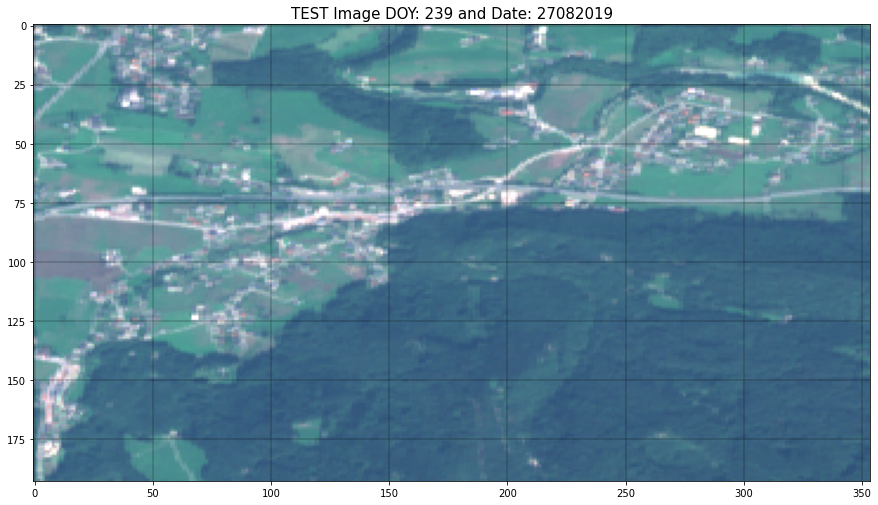

In [14]:
plt.figure(figsize = (15,15))
image = testing
img = np.dstack((image[3, ...]/1500, image[2, ...]/1500, image[1, ...]/1500))
img = np.clip(img, 0, 1)
plt.imshow(np.array(img))
plt.grid(color='black', linewidth=0.3)
plt.title(f'TEST Image DOY: {d} and Date: {Y_M_D}', fontsize=15)
plt.savefig(f'{figures_filepath}/original_images_flood.png', format='png', dpi=300)
plt.show()

**Flood Mask**

Flood Mask shape: (191, 352)


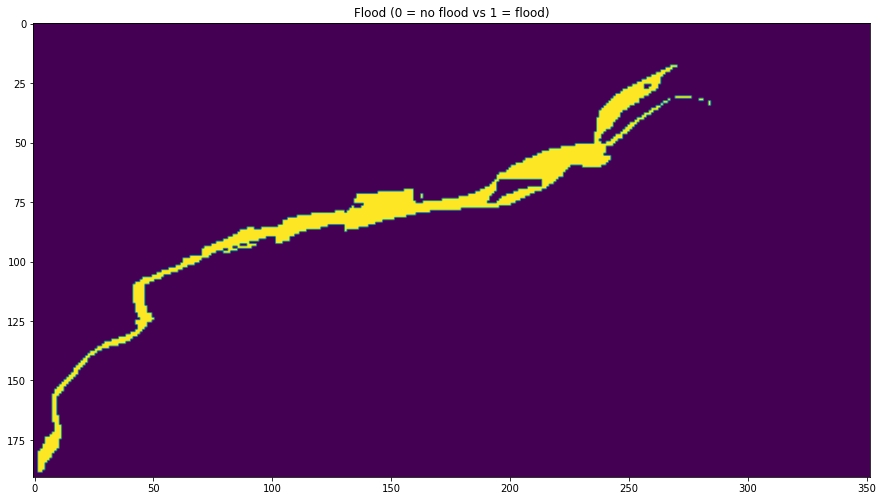

In [15]:
files = sorted(os.listdir(path_images))
for f in files:
    if not f.startswith(('.','Strobler', 'Test')) and f.endswith(('.tif')) and os.path.isfile(os.path.join(path_images, f)):
        # Labels
        flood = gdal_array.LoadFile(path_images+f)
print(f'Flood Mask shape: {flood.shape}')
plt.figure(figsize = (15,15))
plt.title ('Flood (0 = no flood vs 1 = flood)')
plt.savefig(f'{figures_filepath}/flood_mask.png', format='png', dpi=300)
plt.imshow(flood)

plt.figure(figsize = (15,15))
image = testing
img = np.dstack((image[3, ...]/1500, image[2, ...]/1500, image[1, ...]/1500))
img = np.clip(img, 0, 1)
plt.imshow(np.array(img))
plt.contour(flood==1, colors='red', linewidths=1.5)
plt.grid(color='black', linewidth=0.3)
plt.title(f'TEST Image DOY: {d} and Date: {Y_M_D}', fontsize=15)
plt.savefig(f'{figures_filepath}/original_images_floodBound.png', format='png', dpi=300)
plt.show()

# Prepare data for Clustering and AE

**CLUSTERING**

In [16]:
array_kmeans = training[:,:-2, :,:]
array_kmeans = np.transpose(array_kmeans.reshape(array_kmeans.shape[0]*array_kmeans.shape[1], array_kmeans.shape[2]*array_kmeans.shape[3]))
array_kmeans.shape

(68322, 444)

**TRAINING RESHAPED FOR AUTOENCODER**

In [17]:
# Reshape: images, bands, rows*columns
train_AE = training.reshape(training.shape[0], training.shape[1], training.shape[2]*training.shape[3])
# Join per images: bands, images*rows*columns
train_AE = np.concatenate(train_AE, axis=1)
# Transpose: images*rows*columns, bands
train_AE = train_AE.transpose()
train_AE.shape

(2527914, 14)

**TESTING RESHAPED FOR AUTOENCODER**

In [18]:
# Reshape: images, bands, rows*columns
test_AE = testing.reshape(testing.shape[0], testing.shape[1]*testing.shape[2])
# Transpose: images*rows*columns, bands
test_AE = test_AE.transpose()
test_AE.shape

(68322, 14)

# Clustering

In [19]:
# Train K-means
n_features = array_kmeans.shape[1]
print('Training the algorithm...')
start = time.time()
means = KMeans(n_clusters=n_clusters, n_init = 20, random_state = 1996).fit(array_kmeans)
end = time.time()
print(f'--- minutes ---- {(end - start)/60}')

Training the algorithm...
--- minutes ---- 0.544557785987854


In [20]:
labels = means.labels_.reshape(training.shape[2], training.shape[3])

<Figure size 432x288 with 0 Axes>

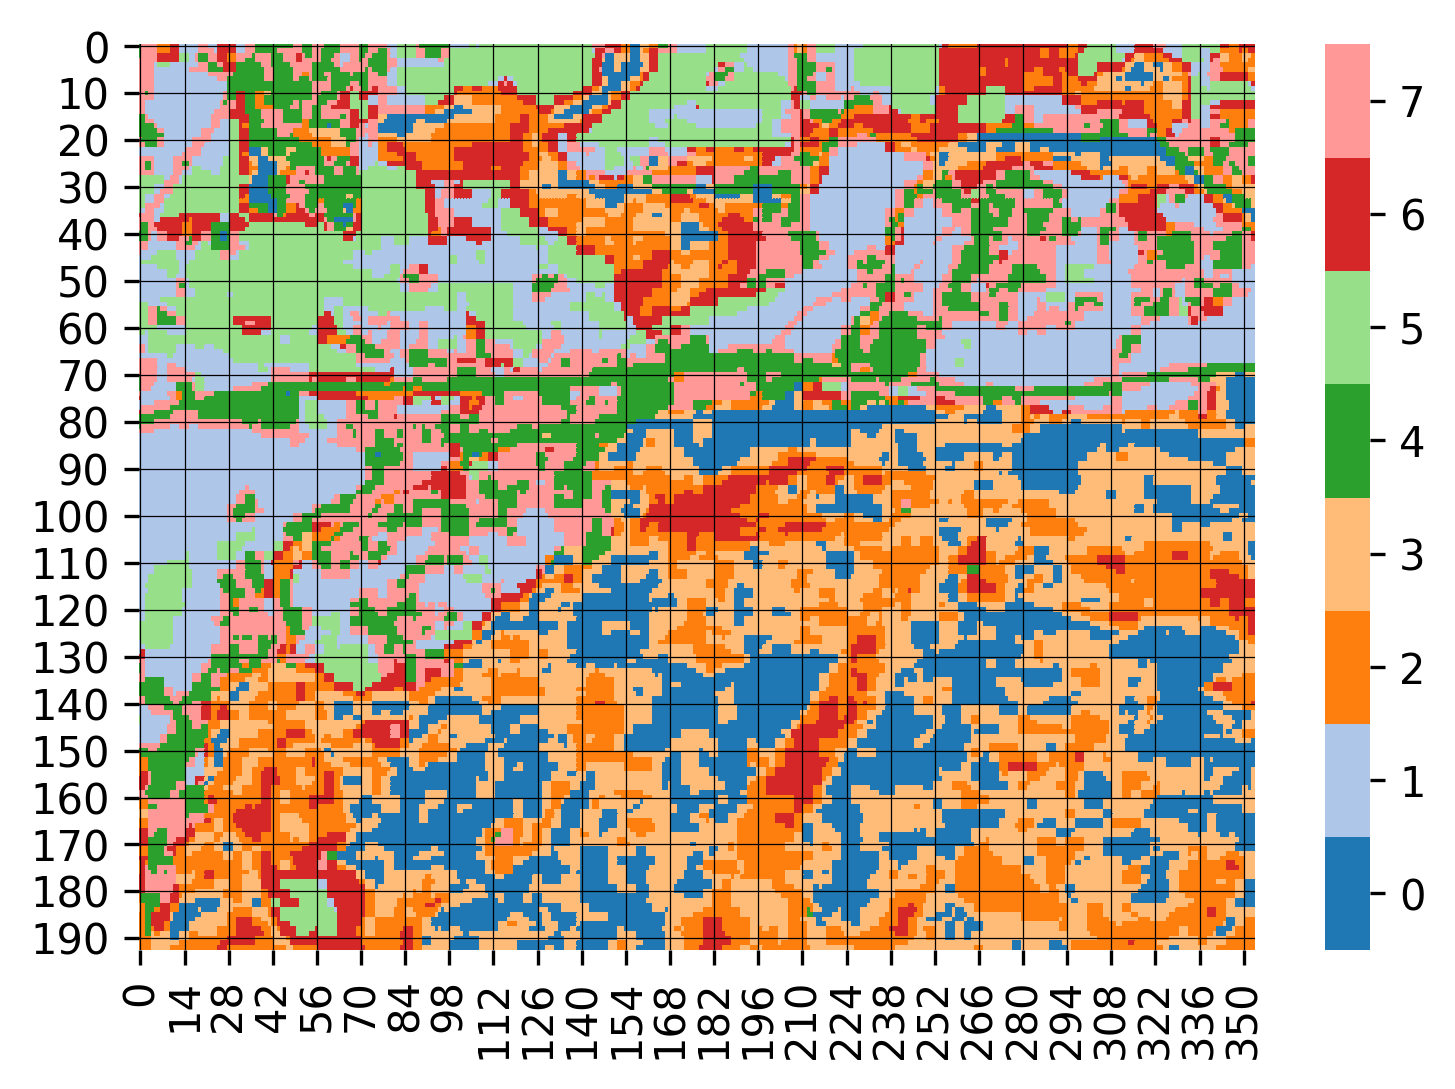

In [21]:
plt.figure()
# discrete colormap (n samples from a given cmap)
cmap = sns.color_palette('tab20', n_clusters) 
fig, ax = plt.subplots(dpi=300) 
ax = sns.heatmap(labels, cmap=cmap) 
# modify colorbar:
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n_clusters * (0.5 + i) for i in range(n_clusters)])
colorbar.set_ticklabels(list(range(n_clusters)))
plt.grid(color='black', linewidth=0.3)
plt.savefig(f'{figures_filepath}/clusters.png', format='png', dpi=300)
plt.show()

**TRUE COLOR COMPOSITE BY CLUSTERS**

<Figure size 432x288 with 0 Axes>

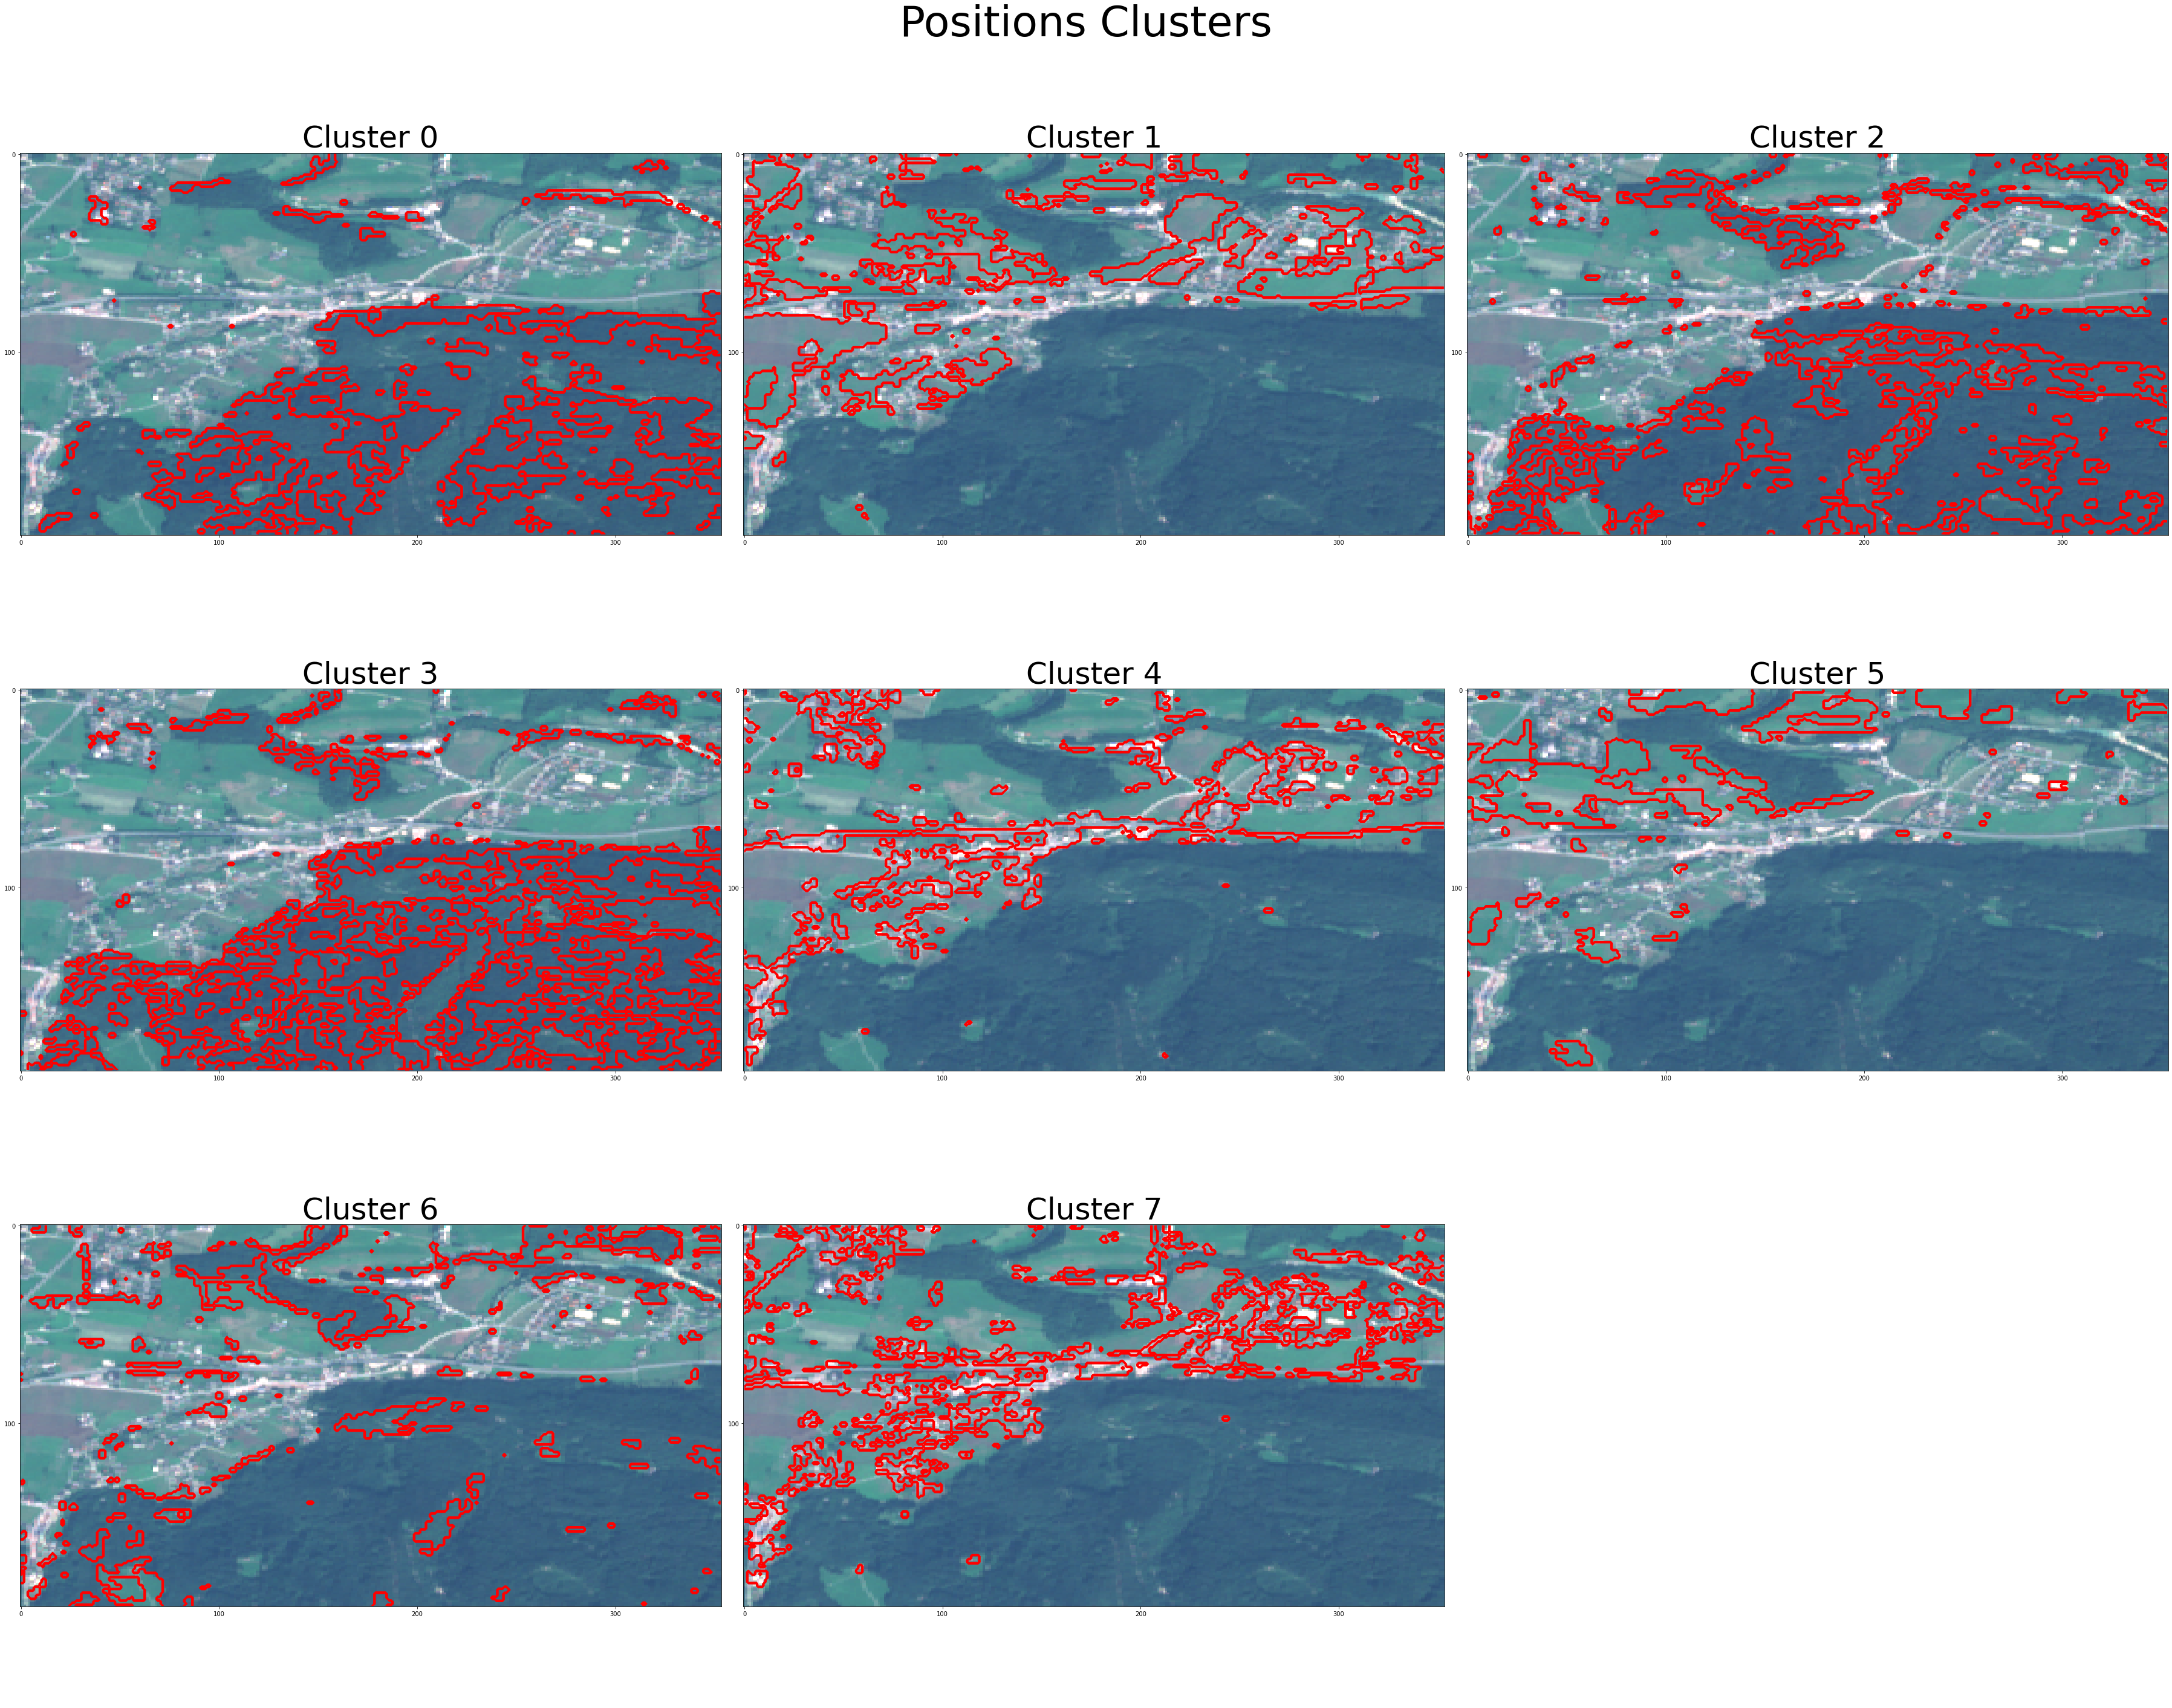

In [22]:
plt.figure()
# Prepare subplots
n_figures = n_clusters
n_rows = int(math.ceil((n_figures)**(1/2))) #add an extra row to have space for the colorbar
n_cols = int(math.ceil(n_figures/n_rows))
rows=[]
columns = []
for row in range(n_rows):
    for col in range(n_cols):
        rows.append(row)
        columns.append(col)

# Subplots and figure title
fig, axs = plt.subplots(n_rows, n_cols, figsize= (50,40))
fig.suptitle(f'Positions Clusters', fontsize = 70)

# Pixels training positions for the cluster
for sp in range(n_figures):
    cluster = labels==sp
    ax = axs[rows[sp], columns[sp]]
    image = testing
    img = np.dstack((image[3, ...]/1500, image[2, ...]/1500, image[1, ...]/1500))
    img = np.clip(img, 0, 1)
    img = ax.imshow(img)
    ax.contour(cluster, colors='red', linewidths=1.5)
    ax.set_xticks(np.arange(cluster.shape[1]+1, step=100))
    ax.set_yticks(np.arange(cluster.shape[0]+1, step=100))
    ax.set_title(f'Cluster {sp}', fontsize=50)

# delete empty figures
for image in range(n_figures, n_rows*n_cols):
    axs[rows[image], columns[image]].set_axis_off()

## Tight layout, save and show
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig(f'{figures_filepath}/clusters_TCC.png', format='png', dpi=300)
plt.show()

**DIFFERENCES BETWEEN CLUSTERS**

- Function to get the positions of all pixels differenciated by their cluster

In [23]:
allClusters_pixels = []
for cluster in range(n_clusters):
    cluster = labels == cluster
    result=np.where(cluster)
    pixels = list(zip(result[0], result[1]))
    allClusters_pixels.append(pixels)
print(f'len:{len(allClusters_pixels)}')

len:8


- Get data per cluster and represent

#Fill in number of figures:
n_figures = training.shape[1]

#Prepare subplots
n_rows = int(math.ceil((n_figures)**(1/2)))
n_cols = int(math.ceil(n_figures/n_rows))
rows=[]
columns = []
for row in range(n_rows):
    for col in range(n_cols):
        rows.append(row)
        columns.append(col)

#Subplots and figure title
fig, axs = plt.subplots(n_rows, n_cols, figsize= (50,40))
fig.suptitle(f'Bands per Cluster', fontsize = 50)

##Plot random selection of pixels per band
for sp in range(n_figures):
    data = []
    label_data = []
    for cluster in range(n_clusters):
        data_cluster = []
        name = f'Cluster {cluster}'
        label_data.append(name)
        pixels = allClusters_pixels[cluster]
        for img in range(training.shape[0]):
            for pixel in pixels:
                pixel = training[img, sp, int(pixel[0]), int(pixel[1])]
                data_cluster.append(pixel)
        data.append(data_cluster)
    data = np.array(data, dtype=object)
    
    # Customize band plot
    ax = axs[rows[sp], columns[sp]]
    ax.boxplot(data.transpose())
    ax.set_title(f'Band: {bands[sp]}', fontsize=25)
    ax.set_xlabel('Cluster', fontsize=20)
    ax.set_ylabel('Reflectance', fontsize=20)
    ax.grid(True, linestyle='-.')
    ax.tick_params(labelsize=20, width=3)
    plt.sca(axs[rows[sp], columns[sp]])
    plt.xticks(list(range(1,len(label_data)+1)), label_data, rotation='vertical')

#delete empty figures
for image in range(n_figures, n_rows*n_cols):
    axs[rows[image], columns[image]].set_axis_off()

#save
plt.tight_layout()
fig.subplots_adjust(top=0.99)
plt.savefig(f'{figures_filepath}/boxplots_clusters.png', format='png', dpi=300)
plt.show()

# Get training and testing pixels

- **Training: by representativity**

Shape: (193, 354)


<Figure size 432x288 with 0 Axes>

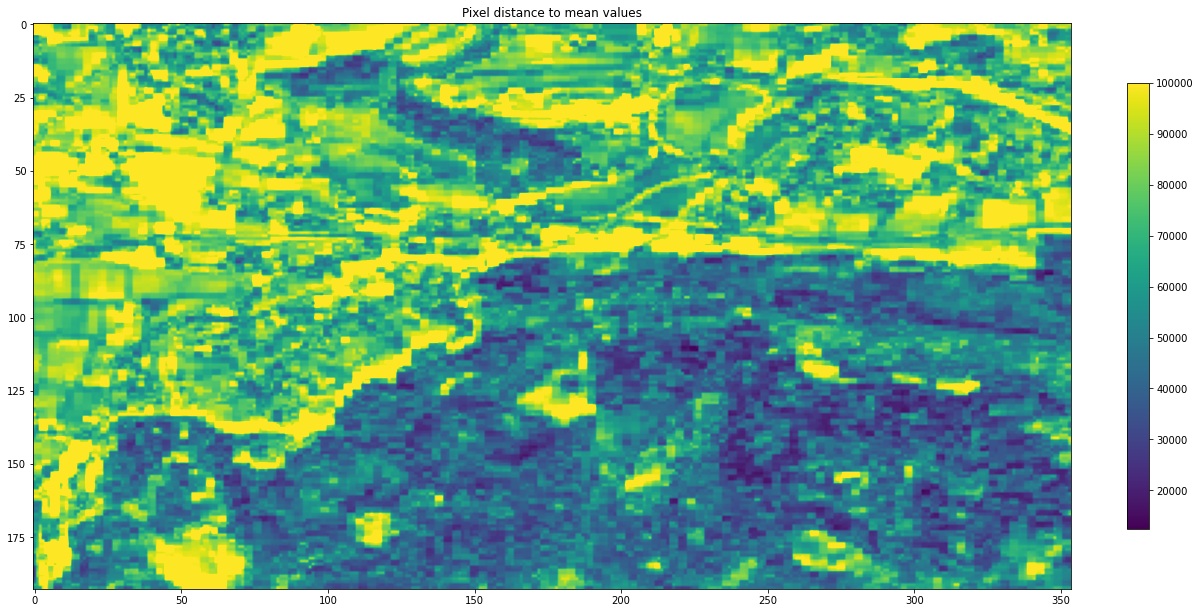

---------------------------------------------------------------------------------------
Cluster: 0
---------------------------------------------------------------------------------------
Min difference: 12415.032313860986
Pixel 0: (110, 224)
Min difference: 12415.032313860986
Pixel 1: (110, 225)
Min difference: 12661.00261461287
Pixel 2: (111, 226)
Min difference: 12910.383287642755
Pixel 3: (159, 303)
Min difference: 13894.185133409872
Pixel 4: (111, 224)
Min difference: 13894.185133409872
Pixel 5: (111, 225)
Min difference: 13989.959381530156
Pixel 6: (85, 347)
Min difference: 14318.220847695575
Pixel 7: (85, 345)
Min difference: 14318.220847695575
Pixel 8: (85, 346)
Min difference: 14894.30299055273
Pixel 9: (110, 226)
Min difference: 15273.6695319061
Pixel 10: (110, 221)
Min difference: 15273.6695319061
Pixel 11: (110, 222)
Min difference: 15313.706407943511
Pixel 12: (159, 304)
Min difference: 15313.706407943511
Pixel 13: (159, 305)
Min difference: 15509.121445537494
Pixel 14: (16

Pixel 145: (153, 240)
Min difference: 19973.31784017678
Pixel 146: (153, 241)
Min difference: 19995.351486793326
Pixel 147: (166, 349)
Min difference: 20004.957347793148
Pixel 148: (145, 237)
Min difference: 20004.957347793148
Pixel 149: (145, 238)
Min difference: 20075.659005590307
Pixel 150: (152, 350)
Min difference: 20075.659005590307
Pixel 151: (152, 351)
Min difference: 20088.05656198129
Pixel 152: (168, 235)
Min difference: 20108.48685907131
Pixel 153: (127, 343)
Min difference: 20108.48685907131
Pixel 154: (127, 344)
Min difference: 20125.232689800847
Pixel 155: (85, 344)
Min difference: 20127.838516868513
Pixel 156: (167, 349)
Min difference: 20127.838516868513
Pixel 157: (167, 350)
Min difference: 20230.49152438732
Pixel 158: (155, 239)
Min difference: 20247.238328898587
Pixel 159: (131, 324)
Min difference: 20247.238328898587
Pixel 160: (131, 325)
Min difference: 20269.21144919934
Pixel 161: (159, 114)
Min difference: 20269.21144919934
Pixel 162: (159, 115)
Min difference: 2

Pixel 296: (115, 259)
Min difference: 21744.882313861002
Pixel 297: (124, 124)
Min difference: 21798.890618469813
Pixel 298: (133, 290)
Min difference: 21798.890618469813
Pixel 299: (133, 291)
Min difference: 21809.13626122941
Pixel 300: (160, 328)
Min difference: 21809.13626122941
Pixel 301: (160, 329)
Min difference: 21818.692840176795
Pixel 302: (144, 240)
Min difference: 21818.692840176795
Pixel 303: (144, 241)
Min difference: 21842.494719876042
Pixel 304: (145, 259)
Min difference: 21842.494719876042
Pixel 305: (145, 260)
Min difference: 21869.69190032717
Pixel 306: (85, 342)
Min difference: 21869.69190032717
Pixel 307: (85, 343)
Min difference: 21916.353212454786
Pixel 308: (148, 242)
Min difference: 21928.442840176773
Pixel 309: (133, 272)
Min difference: 21928.442840176773
Pixel 310: (133, 273)
Min difference: 21972.763738770576
Pixel 311: (143, 258)
Min difference: 22003.786295161553
Pixel 312: (139, 258)
Min difference: 22015.844155966275
Pixel 313: (111, 150)
Min difference:

Pixel 447: (124, 286)
Min difference: 23256.68685907132
Pixel 448: (158, 344)
Min difference: 23256.68685907132
Pixel 449: (158, 345)
Min difference: 23268.37031771794
Pixel 450: (123, 293)
Min difference: 23273.896035665508
Pixel 451: (150, 346)
Min difference: 23306.335509349716
Pixel 452: (171, 314)
Min difference: 23312.72182147733
Pixel 453: (151, 245)
Min difference: 23314.486261229402
Pixel 454: (162, 337)
Min difference: 23352.840772507603
Pixel 455: (173, 245)
Min difference: 23352.840772507603
Pixel 456: (173, 246)
Min difference: 23355.089268748212
Pixel 457: (140, 238)
Min difference: 23355.089268748212
Pixel 458: (140, 239)
Min difference: 23374.447197417183
Pixel 459: (151, 246)
Min difference: 23374.447197417183
Pixel 460: (151, 247)
Min difference: 23398.869941778088
Pixel 461: (41, 176)
Min difference: 23398.869941778088
Pixel 462: (41, 177)
Min difference: 23413.96351686852
Pixel 463: (171, 312)
Min difference: 23413.96351686852
Pixel 464: (171, 313)
Min difference: 2

Pixel 593: (113, 148)
Min difference: 24310.981032003627
Pixel 594: (151, 341)
Min difference: 24310.981032003627
Pixel 595: (151, 342)
Min difference: 24312.137422981097
Pixel 596: (159, 344)
Min difference: 24312.137422981097
Pixel 597: (159, 345)
Min difference: 24335.572727394843
Pixel 598: (152, 252)
Min difference: 24335.572727394843
Pixel 599: (152, 253)
Min difference: 24344.344531906136
Pixel 600: (94, 288)
Min difference: 24350.160731251788
Pixel 601: (150, 165)
Min difference: 24355.0904304999
Pixel 602: (125, 245)
Min difference: 24355.0904304999
Pixel 603: (125, 246)
Min difference: 24358.816900327183
Pixel 604: (83, 172)
Min difference: 24373.996069597655
Pixel 605: (128, 246)
Min difference: 24398.313550800645
Pixel 606: (175, 325)
Min difference: 24398.313550800645
Pixel 607: (176, 324)
Min difference: 24400.852050703113
Pixel 608: (151, 234)
Min difference: 24400.852050703113
Pixel 609: (151, 235)
Min difference: 24410.09641160535
Pixel 610: (123, 263)
Min difference: 

Pixel 748: (161, 338)
Min difference: 25353.591746289363
Pixel 749: (161, 339)
Min difference: 25354.672539424922
Pixel 750: (168, 82)
Min difference: 25386.460697319664
Pixel 751: (127, 330)
Min difference: 25386.460697319664
Pixel 752: (127, 331)
Min difference: 25388.530280123945
Pixel 753: (148, 245)
Min difference: 25389.71690032717
Pixel 754: (166, 264)
Min difference: 25389.71690032717
Pixel 755: (166, 265)
Min difference: 25405.662201079038
Pixel 756: (137, 272)
Min difference: 25405.662201079038
Pixel 757: (137, 273)
Min difference: 25406.97479506403
Pixel 758: (146, 121)
Min difference: 25406.97479506403
Pixel 759: (146, 122)
Min difference: 25420.71862598863
Pixel 760: (175, 156)
Min difference: 25420.71862598863
Pixel 761: (175, 157)
Min difference: 25424.920095815884
Pixel 762: (147, 234)
Min difference: 25424.920095815884
Pixel 763: (147, 235)
Min difference: 25425.815584537668
Pixel 764: (123, 248)
Min difference: 25425.815584537668
Pixel 765: (123, 249)
Min difference: 

Pixel 4: (62, 290)
Min difference: 37934.94636135507
Pixel 5: (95, 37)
Min difference: 38239.902864910066
Pixel 6: (94, 37)
Min difference: 39043.117628607244
Pixel 7: (62, 288)
Min difference: 39043.117628607244
Pixel 8: (62, 289)
Min difference: 39379.43109577585
Pixel 9: (62, 291)
Min difference: 39379.43109577585
Pixel 10: (62, 292)
Min difference: 39961.13038477623
Pixel 11: (61, 290)
Min difference: 40079.63540359685
Pixel 12: (62, 293)
Min difference: 40426.851003764124
Pixel 13: (61, 288)
Min difference: 40426.851003764124
Pixel 14: (61, 289)
Min difference: 40887.50470514428
Pixel 15: (52, 139)
Min difference: 40887.50470514428
Pixel 16: (52, 140)
Min difference: 40986.6469050606
Pixel 17: (97, 41)
Min difference: 40986.6469050606
Pixel 18: (97, 42)
Min difference: 41542.62933918862
Pixel 19: (51, 139)
Min difference: 41542.62933918862
Pixel 20: (51, 140)
Min difference: 41829.587306566325
Pixel 21: (61, 293)
Min difference: 42027.75731911329
Pixel 22: (97, 40)
Min difference:

Pixel 160: (57, 280)
Min difference: 51740.60905478878
Pixel 161: (96, 43)
Min difference: 51805.637285654615
Pixel 162: (9, 230)
Min difference: 51805.637285654615
Pixel 163: (9, 231)
Min difference: 51818.75585529072
Pixel 164: (26, 231)
Min difference: 51857.34242994562
Pixel 165: (35, 301)
Min difference: 51870.43381430365
Pixel 166: (48, 211)
Min difference: 51892.973128398145
Pixel 167: (52, 209)
Min difference: 51892.973128398145
Pixel 168: (52, 210)
Min difference: 51931.953680468396
Pixel 169: (54, 353)
Min difference: 51949.69040150566
Pixel 170: (37, 256)
Min difference: 51949.69040150566
Pixel 171: (37, 257)
Min difference: 51969.7623379339
Pixel 172: (110, 123)
Min difference: 51969.7623379339
Pixel 173: (110, 124)
Min difference: 51975.401191969846
Pixel 174: (109, 125)
Min difference: 51976.121392722685
Pixel 175: (57, 206)
Min difference: 51976.121392722685
Pixel 176: (57, 207)
Min difference: 51977.684127979934
Pixel 177: (37, 255)
Min difference: 51983.428168130464
Pi

Pixel 314: (63, 215)
Min difference: 54289.564512756166
Pixel 315: (63, 216)
Min difference: 54364.9379966542
Pixel 316: (26, 223)
Min difference: 54364.9379966542
Pixel 317: (26, 224)
Min difference: 54373.8041614388
Pixel 318: (26, 225)
Min difference: 54377.35748640735
Pixel 319: (112, 80)
Min difference: 54377.35748640735
Pixel 320: (112, 81)
Min difference: 54419.798724383065
Pixel 321: (106, 88)
Min difference: 54435.03398159767
Pixel 322: (54, 132)
Min difference: 54435.03398159767
Pixel 323: (54, 133)
Min difference: 54458.00742367209
Pixel 324: (35, 296)
Min difference: 54458.00742367209
Pixel 325: (35, 297)
Min difference: 54472.61177331668
Pixel 326: (26, 222)
Min difference: 54560.74644500214
Pixel 327: (22, 170)
Min difference: 54566.80039732326
Pixel 328: (112, 73)
Min difference: 54622.19876620666
Pixel 329: (103, 43)
Min difference: 54676.50386867418
Pixel 330: (108, 120)
Min difference: 54676.50386867418
Pixel 331: (108, 121)
Min difference: 54685.74916352989
Pixel 332

Min difference: 56385.98567544958
Pixel 473: (47, 217)
Min difference: 56402.25878293602
Pixel 474: (67, 290)
Min difference: 56409.28785027193
Pixel 475: (24, 232)
Min difference: 56409.28785027193
Pixel 476: (24, 233)
Min difference: 56427.353094939426
Pixel 477: (25, 228)
Min difference: 56427.353094939426
Pixel 478: (26, 228)
Min difference: 56439.71424090339
Pixel 479: (39, 250)
Min difference: 56439.71424090339
Pixel 480: (39, 251)
Min difference: 56448.11846507737
Pixel 481: (12, 3)
Min difference: 56448.11846507737
Pixel 482: (12, 4)
Min difference: 56487.844730238394
Pixel 483: (96, 44)
Min difference: 56487.844730238394
Pixel 484: (96, 45)
Min difference: 56519.796424090375
Pixel 485: (40, 243)
Min difference: 56519.796424090375
Pixel 486: (40, 244)
Min difference: 56525.605918025925
Pixel 487: (109, 22)
Min difference: 56525.605918025925
Pixel 488: (109, 23)
Min difference: 56537.42210372227
Pixel 489: (94, 16)
Min difference: 56542.328000836445
Pixel 490: (57, 217)
Min diff

Pixel 628: (45, 15)
Min difference: 58048.25271852782
Pixel 629: (16, 337)
Min difference: 58048.25271852782
Pixel 630: (16, 338)
Min difference: 58079.10403596823
Pixel 631: (52, 217)
Min difference: 58095.25104558767
Pixel 632: (37, 246)
Min difference: 58105.24309912169
Pixel 633: (33, 295)
Min difference: 58112.78847762444
Pixel 634: (54, 134)
Min difference: 58119.26296528648
Pixel 635: (60, 211)
Min difference: 58123.0379548306
Pixel 636: (44, 248)
Min difference: 58125.63770388958
Pixel 637: (52, 123)
Min difference: 58125.63770388958
Pixel 638: (52, 124)
Min difference: 58135.53063571732
Pixel 639: (40, 246)
Min difference: 58143.58647009619
Pixel 640: (1, 178)
Min difference: 58143.58647009619
Pixel 641: (1, 179)
Min difference: 58154.41917607697
Pixel 642: (44, 120)
Min difference: 58155.16969887075
Pixel 643: (115, 67)
Min difference: 58155.16969887075
Pixel 644: (115, 68)
Min difference: 58160.31754496025
Pixel 645: (59, 331)
Min difference: 58160.31754496025
Pixel 646: (59

Pixel 780: (15, 193)
Min difference: 59151.01369719787
Pixel 781: (15, 194)
Min difference: 59160.674299456274
Pixel 782: (50, 138)
Min difference: 59174.70002091176
Pixel 783: (55, 307)
Min difference: 59174.70002091176
Pixel 784: (55, 308)
Min difference: 59183.34556670847
Pixel 785: (55, 353)
Min difference: 59196.0220618988
Pixel 786: (58, 341)
Min difference: 59196.0220618988
Pixel 787: (58, 342)
Min difference: 59217.304579673764
Pixel 788: (62, 217)
Min difference: 59308.02770807189
Pixel 789: (62, 211)
Min difference: 59320.81315349228
Pixel 790: (66, 250)
Min difference: 59333.599853617714
Pixel 791: (54, 206)
Min difference: 59333.599853617714
Pixel 792: (54, 207)
Min difference: 59346.375261396934
Pixel 793: (44, 127)
Min difference: 59346.375261396934
Pixel 794: (44, 128)
Min difference: 59352.622856545386
Pixel 795: (67, 250)
Min difference: 59356.98442074449
Pixel 796: (114, 58)
Min difference: 59356.98442074449
Pixel 797: (114, 59)
Min difference: 59376.967482225016
Pixe

Pixel 2: (113, 244)
Min difference: 21174.53368794327
Pixel 3: (114, 242)
Min difference: 21174.53368794327
Pixel 4: (114, 243)
Min difference: 21741.493695823494
Pixel 5: (110, 242)
Min difference: 21741.493695823494
Pixel 6: (110, 243)
Min difference: 22013.7464539007
Pixel 7: (114, 244)
Min difference: 22178.63455476754
Pixel 8: (107, 242)
Min difference: 22406.91430260047
Pixel 9: (108, 242)
Min difference: 22614.44897557132
Pixel 10: (106, 169)
Min difference: 22614.44897557132
Pixel 11: (106, 170)
Min difference: 22659.65878644602
Pixel 12: (113, 242)
Min difference: 22659.65878644602
Pixel 13: (113, 243)
Min difference: 22916.22360126083
Pixel 14: (109, 235)
Min difference: 23247.739755713137
Pixel 15: (98, 270)
Min difference: 23320.083530338863
Pixel 16: (107, 169)
Min difference: 23320.083530338863
Pixel 17: (107, 170)
Min difference: 23356.293538219074
Pixel 18: (113, 240)
Min difference: 23356.293538219074
Pixel 19: (114, 239)
Min difference: 23610.405634357758
Pixel 20: (1

Pixel 156: (143, 297)
Min difference: 30691.76044129238
Pixel 157: (109, 232)
Min difference: 30716.21138691883
Pixel 158: (45, 181)
Min difference: 30721.627265563457
Pixel 159: (123, 222)
Min difference: 30730.772655634388
Pixel 160: (108, 246)
Min difference: 30730.772655634388
Pixel 161: (108, 247)
Min difference: 30790.217691095353
Pixel 162: (136, 42)
Min difference: 30790.217691095353
Pixel 163: (136, 43)
Min difference: 30792.372537431056
Pixel 164: (97, 265)
Min difference: 30792.372537431056
Pixel 165: (97, 266)
Min difference: 30805.561071710017
Pixel 166: (97, 285)
Min difference: 30808.46631205674
Pixel 167: (10, 324)
Min difference: 30821.01024428685
Pixel 168: (37, 136)
Min difference: 30821.01024428685
Pixel 169: (37, 137)
Min difference: 30832.67080378252
Pixel 170: (92, 163)
Min difference: 30838.893026004724
Pixel 171: (98, 197)
Min difference: 30838.893026004724
Pixel 172: (98, 198)
Min difference: 30843.24054373526
Pixel 173: (119, 230)
Min difference: 30843.240543

Pixel 305: (118, 241)
Min difference: 33209.242119779345
Pixel 306: (90, 215)
Min difference: 33269.01280535854
Pixel 307: (94, 167)
Min difference: 33269.01280535854
Pixel 308: (94, 168)
Min difference: 33283.851457840836
Pixel 309: (158, 131)
Min difference: 33297.75472813239
Pixel 310: (98, 199)
Min difference: 33303.02580772264
Pixel 311: (102, 283)
Min difference: 33303.02580772264
Pixel 312: (102, 284)
Min difference: 33336.23758865251
Pixel 313: (175, 202)
Min difference: 33336.23758865251
Pixel 314: (175, 203)
Min difference: 33353.20606776991
Pixel 315: (128, 113)
Min difference: 33353.20606776991
Pixel 316: (128, 114)
Min difference: 33374.57131599685
Pixel 317: (110, 233)
Min difference: 33374.57131599685
Pixel 318: (110, 234)
Min difference: 33381.52423167849
Pixel 319: (122, 222)
Min difference: 33391.51398739168
Pixel 320: (17, 100)
Min difference: 33393.94247438927
Pixel 321: (94, 169)
Min difference: 33415.82407407412
Pixel 322: (92, 166)
Min difference: 33443.082348305

Pixel 456: (36, 141)
Min difference: 35369.104412923596
Pixel 457: (119, 232)
Min difference: 35371.07545311272
Pixel 458: (97, 282)
Min difference: 35372.66863672185
Pixel 459: (120, 336)
Min difference: 35373.40760441295
Pixel 460: (173, 202)
Min difference: 35373.40760441295
Pixel 461: (173, 203)
Min difference: 35392.92237982666
Pixel 462: (143, 31)
Min difference: 35399.049842395616
Pixel 463: (36, 138)
Min difference: 35424.17021276598
Pixel 464: (173, 204)
Min difference: 35444.7350275808
Pixel 465: (113, 245)
Min difference: 35444.7350275808
Pixel 466: (113, 246)
Min difference: 35476.21611505127
Pixel 467: (95, 166)
Min difference: 35479.23758865251
Pixel 468: (159, 154)
Min difference: 35479.23758865251
Pixel 469: (159, 155)
Min difference: 35482.13435776204
Pixel 470: (40, 163)
Min difference: 35503.576044129266
Pixel 471: (135, 223)
Min difference: 35503.576044129266
Pixel 472: (135, 224)
Min difference: 35524.34436564226
Pixel 473: (33, 134)
Min difference: 35524.344365642

Pixel 605: (113, 301)
Min difference: 36438.533293932254
Pixel 606: (113, 302)
Min difference: 36443.61465721042
Pixel 607: (174, 14)
Min difference: 36471.25078802208
Pixel 608: (118, 236)
Min difference: 36471.25078802208
Pixel 609: (118, 237)
Min difference: 36486.504334121404
Pixel 610: (111, 300)
Min difference: 36493.105200945676
Pixel 611: (135, 118)
Min difference: 36493.105200945676
Pixel 612: (135, 119)
Min difference: 36496.39322301024
Pixel 613: (107, 171)
Min difference: 36508.84219858158
Pixel 614: (14, 118)
Min difference: 36553.05299448389
Pixel 615: (141, 40)
Min difference: 36567.22635933809
Pixel 616: (156, 74)
Min difference: 36567.22635933809
Pixel 617: (156, 75)
Min difference: 36585.01832151301
Pixel 618: (175, 20)
Min difference: 36588.80279747829
Pixel 619: (107, 177)
Min difference: 36597.74468085104
Pixel 620: (173, 14)
Min difference: 36598.62155240349
Pixel 621: (38, 135)
Min difference: 36608.27639873921
Pixel 622: (104, 208)
Min difference: 36616.12608353

Pixel 757: (34, 139)
Min difference: 37620.95685579203
Pixel 758: (170, 153)
Min difference: 37620.95685579203
Pixel 759: (170, 154)
Min difference: 37621.64913317573
Pixel 760: (142, 29)
Min difference: 37621.64913317573
Pixel 761: (142, 30)
Min difference: 37674.00039401105
Pixel 762: (128, 116)
Min difference: 37674.00039401105
Pixel 763: (128, 117)
Min difference: 37679.11367218284
Pixel 764: (21, 93)
Min difference: 37679.311268715566
Pixel 765: (189, 192)
Min difference: 37679.311268715566
Pixel 766: (189, 193)
Min difference: 37686.31382978728
Pixel 767: (170, 201)
Min difference: 37688.326832151375
Pixel 768: (175, 293)
Min difference: 37689.85835303394
Pixel 769: (95, 234)
Min difference: 37689.85835303394
Pixel 770: (95, 235)
Min difference: 37695.97123719464
Pixel 771: (173, 44)
Min difference: 37710.15464933016
Pixel 772: (106, 177)
Min difference: 37716.29669030737
Pixel 773: (186, 192)
Min difference: 37716.29669030737
Pixel 774: (186, 193)
Min difference: 37718.546887312

Pixel 3: (89, 160)
Min difference: 17273.972686873087
Pixel 4: (172, 273)
Min difference: 17273.972686873087
Pixel 5: (172, 274)
Min difference: 17410.00189838196
Pixel 6: (133, 237)
Min difference: 17434.99904312168
Pixel 7: (89, 161)
Min difference: 17434.99904312168
Pixel 8: (89, 162)
Min difference: 17667.30228640452
Pixel 9: (125, 296)
Min difference: 17759.884613075585
Pixel 10: (171, 273)
Min difference: 17759.884613075585
Pixel 11: (171, 274)
Min difference: 17832.958483783535
Pixel 12: (167, 307)
Min difference: 17832.958483783535
Pixel 13: (167, 308)
Min difference: 17871.700705029616
Pixel 14: (131, 296)
Min difference: 17871.700705029616
Pixel 15: (131, 297)
Min difference: 18055.74756058272
Pixel 16: (140, 286)
Min difference: 18275.500114942603
Pixel 17: (88, 159)
Min difference: 18275.500114942603
Pixel 18: (89, 158)
Min difference: 18412.87216706929
Pixel 19: (132, 298)
Min difference: 18495.818868877643
Pixel 20: (128, 302)
Min difference: 18551.672152426952
Pixel 21: 

Pixel 150: (170, 347)
Min difference: 21408.461385899493
Pixel 151: (91, 262)
Min difference: 21408.461385899493
Pixel 152: (91, 263)
Min difference: 21410.342699319117
Pixel 153: (133, 308)
Min difference: 21411.865734680483
Pixel 154: (157, 151)
Min difference: 21411.865734680483
Pixel 155: (157, 152)
Min difference: 21423.588251702102
Pixel 156: (168, 331)
Min difference: 21423.588251702102
Pixel 157: (168, 332)
Min difference: 21453.184049344716
Pixel 158: (125, 219)
Min difference: 21458.915445493883
Pixel 159: (118, 223)
Min difference: 21487.957615491694
Pixel 160: (92, 262)
Min difference: 21487.957615491694
Pixel 161: (92, 263)
Min difference: 21508.10571271686
Pixel 162: (171, 342)
Min difference: 21518.942303975324
Pixel 163: (169, 331)
Min difference: 21518.942303975324
Pixel 164: (169, 332)
Min difference: 21540.229587085407
Pixel 165: (131, 349)
Min difference: 21540.229587085407
Pixel 166: (131, 350)
Min difference: 21543.997589135477
Pixel 167: (130, 302)
Min difference

Min difference: 23405.411162603494
Pixel 296: (104, 332)
Min difference: 23405.411162603494
Pixel 297: (104, 333)
Min difference: 23420.258442785016
Pixel 298: (183, 250)
Min difference: 23420.258442785016
Pixel 299: (183, 251)
Min difference: 23429.370739439175
Pixel 300: (87, 160)
Min difference: 23440.774512775533
Pixel 301: (177, 309)
Min difference: 23440.774512775533
Pixel 302: (177, 310)
Min difference: 23510.53722307633
Pixel 303: (132, 320)
Min difference: 23513.692515557574
Pixel 304: (154, 65)
Min difference: 23513.692515557574
Pixel 305: (154, 66)
Min difference: 23528.837182077834
Pixel 306: (174, 245)
Min difference: 23528.837182077834
Pixel 307: (174, 246)
Min difference: 23539.963462186104
Pixel 308: (116, 199)
Min difference: 23539.963462186104
Pixel 309: (116, 200)
Min difference: 23555.45705615342
Pixel 310: (133, 307)
Min difference: 23567.955774946844
Pixel 311: (163, 316)
Min difference: 23567.955774946844
Pixel 312: (163, 317)
Min difference: 23573.13448495495
Pi

Pixel 449: (114, 199)
Min difference: 24599.615340068805
Pixel 450: (114, 200)
Min difference: 24602.811547697485
Pixel 451: (151, 135)
Min difference: 24616.34211362469
Pixel 452: (177, 306)
Min difference: 24616.34211362469
Pixel 453: (177, 307)
Min difference: 24622.848007174718
Pixel 454: (167, 267)
Min difference: 24622.848007174718
Pixel 455: (167, 268)
Min difference: 24631.990770188124
Pixel 456: (173, 287)
Min difference: 24633.00103009012
Pixel 457: (167, 72)
Min difference: 24638.78284867121
Pixel 458: (110, 199)
Min difference: 24656.306616150614
Pixel 459: (137, 130)
Min difference: 24656.306616150614
Pixel 460: (137, 131)
Min difference: 24657.044737535733
Pixel 461: (157, 153)
Min difference: 24672.906796251526
Pixel 462: (115, 205)
Min difference: 24672.906796251526
Pixel 463: (115, 206)
Min difference: 24678.723181052745
Pixel 464: (87, 169)
Min difference: 24685.839514605716
Pixel 465: (170, 278)
Min difference: 24688.9437682114
Pixel 466: (142, 305)
Min difference: 2

Pixel 605: (87, 167)
Min difference: 25721.935714913205
Pixel 606: (87, 168)
Min difference: 25737.327188666888
Pixel 607: (40, 169)
Min difference: 25738.330546159996
Pixel 608: (124, 216)
Min difference: 25788.676116114002
Pixel 609: (167, 73)
Min difference: 25789.694335602886
Pixel 610: (136, 238)
Min difference: 25789.694335602886
Pixel 611: (136, 239)
Min difference: 25817.06033164954
Pixel 612: (171, 168)
Min difference: 25817.06033164954
Pixel 613: (171, 169)
Min difference: 25832.529828684346
Pixel 614: (142, 307)
Min difference: 25835.758395929413
Pixel 615: (143, 313)
Min difference: 25836.13054176741
Pixel 616: (139, 157)
Min difference: 25839.38889596599
Pixel 617: (166, 322)
Min difference: 25839.38889596599
Pixel 618: (166, 323)
Min difference: 25840.982214657073
Pixel 619: (33, 154)
Min difference: 25841.03916318909
Pixel 620: (163, 249)
Min difference: 25841.03916318909
Pixel 621: (163, 250)
Min difference: 25889.497772164934
Pixel 622: (173, 330)
Min difference: 25901

Pixel 759: (114, 203)
Min difference: 26682.34937184282
Pixel 760: (114, 220)
Min difference: 26717.209756936893
Pixel 761: (145, 65)
Min difference: 26735.964487151316
Pixel 762: (112, 196)
Min difference: 26735.964487151316
Pixel 763: (112, 197)
Min difference: 26738.75730800209
Pixel 764: (108, 157)
Min difference: 26738.75730800209
Pixel 765: (108, 158)
Min difference: 26745.483339190265
Pixel 766: (138, 302)
Min difference: 26745.483339190265
Pixel 767: (138, 303)
Min difference: 26745.585919174235
Pixel 768: (14, 107)
Min difference: 26745.585919174235
Pixel 769: (14, 108)
Min difference: 26748.35287575955
Pixel 770: (137, 305)
Min difference: 26748.35287575955
Pixel 771: (137, 306)
Min difference: 26748.885428655172
Pixel 772: (175, 285)
Min difference: 26748.885428655172
Pixel 773: (175, 286)
Min difference: 26755.318978695344
Pixel 774: (157, 328)
Min difference: 26761.950796544414
Pixel 775: (139, 283)
Min difference: 26764.716006296185
Pixel 776: (138, 308)
Min difference: 2

Min difference: 31798.335392320565
Pixel 1: (7, 62)
Min difference: 31798.335392320565
Pixel 2: (7, 63)
Min difference: 32137.560434056744
Pixel 3: (63, 244)
Min difference: 33173.05592654426
Pixel 4: (63, 247)
Min difference: 33223.63989983307
Pixel 5: (6, 62)
Min difference: 33223.63989983307
Pixel 6: (6, 63)
Min difference: 33963.92871452418
Pixel 7: (28, 62)
Min difference: 33963.95642737899
Pixel 8: (6, 61)
Min difference: 34406.37946577631
Pixel 9: (9, 36)
Min difference: 34919.0465776294
Pixel 10: (4, 74)
Min difference: 34919.0465776294
Pixel 11: (4, 75)
Min difference: 35182.880300500794
Pixel 12: (67, 183)
Min difference: 35591.58714524204
Pixel 13: (63, 245)
Min difference: 35591.58714524204
Pixel 14: (63, 246)
Min difference: 36139.03555926542
Pixel 15: (39, 293)
Min difference: 36139.03555926542
Pixel 16: (39, 294)
Min difference: 36391.4853088481
Pixel 17: (35, 265)
Min difference: 36391.4853088481
Pixel 18: (35, 266)
Min difference: 36852.25592654421
Pixel 19: (67, 181)


Pixel 160: (50, 261)
Min difference: 43571.904674457415
Pixel 161: (50, 262)
Min difference: 43580.82020033391
Pixel 162: (55, 258)
Min difference: 43580.82020033391
Pixel 163: (55, 259)
Min difference: 43602.62587646079
Pixel 164: (60, 236)
Min difference: 43602.62587646079
Pixel 165: (60, 237)
Min difference: 43611.18514190322
Pixel 166: (6, 64)
Min difference: 43618.29999999999
Pixel 167: (73, 115)
Min difference: 43627.78614357262
Pixel 168: (27, 59)
Min difference: 43813.55008347244
Pixel 169: (72, 142)
Min difference: 43893.155425709556
Pixel 170: (45, 346)
Min difference: 43912.09232053421
Pixel 171: (113, 36)
Min difference: 43986.09165275461
Pixel 172: (31, 289)
Min difference: 43997.3694490818
Pixel 173: (59, 245)
Min difference: 43997.3694490818
Pixel 174: (59, 246)
Min difference: 44035.160767946596
Pixel 175: (97, 132)
Min difference: 44043.18881469121
Pixel 176: (67, 152)
Min difference: 44056.90901502501
Pixel 177: (65, 172)
Min difference: 44056.90901502501
Pixel 178: (

Pixel 314: (68, 208)
Min difference: 47097.04056761264
Pixel 315: (68, 209)
Min difference: 47157.398497495844
Pixel 316: (66, 245)
Min difference: 47157.398497495844
Pixel 317: (66, 246)
Min difference: 47166.383138564255
Pixel 318: (26, 57)
Min difference: 47166.383138564255
Pixel 319: (26, 58)
Min difference: 47169.28430717868
Pixel 320: (4, 73)
Min difference: 47186.61051752926
Pixel 321: (55, 255)
Min difference: 47186.61051752926
Pixel 322: (55, 256)
Min difference: 47189.63121869782
Pixel 323: (71, 141)
Min difference: 47189.63121869782
Pixel 324: (71, 142)
Min difference: 47196.586143572655
Pixel 325: (56, 324)
Min difference: 47196.80884808015
Pixel 326: (84, 97)
Min difference: 47196.80884808015
Pixel 327: (84, 98)
Min difference: 47211.29799666116
Pixel 328: (30, 272)
Min difference: 47211.29799666116
Pixel 329: (30, 273)
Min difference: 47256.18113522536
Pixel 330: (114, 30)
Min difference: 47325.87295492481
Pixel 331: (71, 152)
Min difference: 47351.562437395696
Pixel 332:

Pixel 469: (12, 45)
Min difference: 49723.54006677799
Pixel 470: (72, 146)
Min difference: 49735.20617696157
Pixel 471: (81, 103)
Min difference: 49735.20617696157
Pixel 472: (81, 104)
Min difference: 49735.83255425707
Pixel 473: (71, 231)
Min difference: 49745.93539232055
Pixel 474: (37, 295)
Min difference: 49749.822203672826
Pixel 475: (131, 30)
Min difference: 49749.822203672826
Pixel 476: (131, 31)
Min difference: 49770.25492487475
Pixel 477: (153, 4)
Min difference: 49770.25492487475
Pixel 478: (153, 5)
Min difference: 49797.112353923236
Pixel 479: (100, 55)
Min difference: 49797.40417362271
Pixel 480: (81, 96)
Min difference: 49812.3674457429
Pixel 481: (65, 178)
Min difference: 49812.3674457429
Pixel 482: (65, 179)
Min difference: 49827.81519198659
Pixel 483: (69, 153)
Min difference: 49827.81519198659
Pixel 484: (69, 154)
Min difference: 49841.60150250414
Pixel 485: (47, 264)
Min difference: 49862.86961602674
Pixel 486: (139, 7)
Min difference: 49895.25726210348
Pixel 487: (53

Pixel 625: (101, 113)
Min difference: 51723.74507512525
Pixel 626: (49, 202)
Min difference: 51737.215859766264
Pixel 627: (71, 232)
Min difference: 51737.215859766264
Pixel 628: (71, 233)
Min difference: 51745.514691151955
Pixel 629: (33, 329)
Min difference: 51760.04924874795
Pixel 630: (104, 99)
Min difference: 51760.04924874795
Pixel 631: (104, 100)
Min difference: 51803.54340567617
Pixel 632: (28, 60)
Min difference: 51803.54340567617
Pixel 633: (28, 61)
Min difference: 51805.00818030053
Pixel 634: (57, 321)
Min difference: 51805.98013355592
Pixel 635: (74, 32)
Min difference: 51816.946744574234
Pixel 636: (70, 155)
Min difference: 51824.846577629345
Pixel 637: (96, 138)
Min difference: 51824.99215358934
Pixel 638: (23, 50)
Min difference: 51861.57545909843
Pixel 639: (95, 142)
Min difference: 51861.57545909843
Pixel 640: (95, 143)
Min difference: 51862.02320534222
Pixel 641: (94, 121)
Min difference: 51862.02320534222
Pixel 642: (94, 122)
Min difference: 51865.24924874789
Pixel 6

Pixel 775: (97, 138)
Min difference: 53604.14040066773
Pixel 776: (12, 57)
Min difference: 53627.907011686155
Pixel 777: (71, 150)
Min difference: 53627.907011686155
Pixel 778: (71, 151)
Min difference: 53638.456260434104
Pixel 779: (42, 267)
Min difference: 53652.87295492497
Pixel 780: (22, 340)
Min difference: 53652.87295492497
Pixel 781: (22, 341)
Min difference: 53687.242904841376
Pixel 782: (41, 347)
Min difference: 53698.66527545912
Pixel 783: (64, 69)
Min difference: 53698.80717863109
Pixel 784: (79, 2)
Min difference: 53698.80717863109
Pixel 785: (79, 3)
Min difference: 53724.46727879801
Pixel 786: (39, 283)
Min difference: 53724.46727879801
Pixel 787: (39, 284)
Min difference: 53744.43489148583
Pixel 788: (126, 79)
Min difference: 53744.43489148583
Pixel 789: (126, 80)
Min difference: 53759.37579298827
Pixel 790: (20, 45)
Min difference: 53759.37579298827
Pixel 791: (20, 46)
Min difference: 53765.174791318816
Pixel 792: (97, 95)
Min difference: 53803.680968280416
Pixel 793: (7

Pixel 2: (7, 191)
Min difference: 47940.525824840195
Pixel 3: (45, 130)
Min difference: 47940.525824840195
Pixel 4: (45, 131)
Min difference: 48023.03731214373
Pixel 5: (62, 113)
Min difference: 48023.03731214373
Pixel 6: (62, 114)
Min difference: 48340.53307997924
Pixel 7: (17, 155)
Min difference: 48341.2069442045
Pixel 8: (16, 170)
Min difference: 48538.85904301258
Pixel 9: (17, 153)
Min difference: 48538.85904301258
Pixel 10: (17, 154)
Min difference: 48649.651062359626
Pixel 11: (16, 168)
Min difference: 48649.651062359626
Pixel 12: (16, 169)
Min difference: 48733.90810157193
Pixel 13: (46, 130)
Min difference: 48733.90810157193
Pixel 14: (46, 131)
Min difference: 48773.16617723266
Pixel 15: (17, 156)
Min difference: 48773.16617723266
Pixel 16: (17, 157)
Min difference: 48866.38141302469
Pixel 17: (20, 202)
Min difference: 48866.38141302469
Pixel 18: (20, 203)
Min difference: 49311.8797719813
Pixel 19: (16, 158)
Min difference: 49491.58386595269
Pixel 20: (62, 112)
Min difference:

Pixel 161: (16, 151)
Min difference: 55782.38279495592
Pixel 162: (20, 199)
Min difference: 55782.38279495592
Pixel 163: (20, 200)
Min difference: 55862.79633788219
Pixel 164: (48, 138)
Min difference: 56042.44152703401
Pixel 165: (47, 138)
Min difference: 56233.6498531698
Pixel 166: (61, 116)
Min difference: 56270.02556572805
Pixel 167: (50, 147)
Min difference: 56362.82380376577
Pixel 168: (61, 110)
Min difference: 56362.82380376577
Pixel 169: (61, 111)
Min difference: 56371.212471929466
Pixel 170: (11, 202)
Min difference: 56371.212471929466
Pixel 171: (11, 203)
Min difference: 56371.250129556065
Pixel 172: (62, 117)
Min difference: 56371.250129556065
Pixel 173: (62, 118)
Min difference: 56420.4017965106
Pixel 174: (20, 198)
Min difference: 56487.82242183447
Pixel 175: (51, 117)
Min difference: 56487.82242183447
Pixel 176: (51, 118)
Min difference: 56552.64829849709
Pixel 177: (53, 25)
Min difference: 56552.64829849709
Pixel 178: (53, 26)
Min difference: 56651.75833477285
Pixel 179:

Pixel 317: (50, 79)
Min difference: 60505.91812057352
Pixel 318: (51, 104)
Min difference: 60536.923130074225
Pixel 319: (52, 25)
Min difference: 60536.923130074225
Pixel 320: (52, 26)
Min difference: 60543.785109690725
Pixel 321: (7, 120)
Min difference: 60543.785109690725
Pixel 322: (7, 121)
Min difference: 60580.45966488162
Pixel 323: (4, 251)
Min difference: 60601.62394195888
Pixel 324: (40, 87)
Min difference: 60601.62394195888
Pixel 325: (40, 88)
Min difference: 60634.86215235789
Pixel 326: (8, 235)
Min difference: 60646.40507859737
Pixel 327: (40, 86)
Min difference: 60655.64294351351
Pixel 328: (54, 24)
Min difference: 60675.049749524886
Pixel 329: (6, 125)
Min difference: 60698.0390395578
Pixel 330: (50, 80)
Min difference: 60698.0390395578
Pixel 331: (50, 81)
Min difference: 60704.30350665054
Pixel 332: (125, 1)
Min difference: 60738.54206253243
Pixel 333: (57, 62)
Min difference: 60738.54206253243
Pixel 334: (57, 63)
Min difference: 60770.85109690791
Pixel 335: (20, 183)
Min

Pixel 473: (60, 118)
Min difference: 64288.67904646743
Pixel 474: (60, 116)
Min difference: 64295.62877871827
Pixel 475: (21, 188)
Min difference: 64317.52167904648
Pixel 476: (45, 135)
Min difference: 64349.931421661735
Pixel 477: (21, 183)
Min difference: 64349.931421661735
Pixel 478: (21, 184)
Min difference: 64387.66557263775
Pixel 479: (126, 1)
Min difference: 64411.4233891864
Pixel 480: (64, 33)
Min difference: 64416.340646052864
Pixel 481: (55, 113)
Min difference: 64462.25669372952
Pixel 482: (62, 34)
Min difference: 64462.25669372952
Pixel 483: (62, 35)
Min difference: 64472.10329936091
Pixel 484: (12, 210)
Min difference: 64506.79512869241
Pixel 485: (49, 79)
Min difference: 64534.49058559332
Pixel 486: (9, 189)
Min difference: 64561.08913456554
Pixel 487: (19, 186)
Min difference: 64561.08913456554
Pixel 488: (19, 187)
Min difference: 64577.03282086707
Pixel 489: (12, 201)
Min difference: 64593.770944895485
Pixel 490: (61, 119)
Min difference: 64644.2046985662
Pixel 491: (4,

Min difference: 67174.48799447226
Pixel 628: (8, 238)
Min difference: 67175.42027984108
Pixel 629: (0, 191)
Min difference: 67175.42027984108
Pixel 630: (0, 192)
Min difference: 67184.07116945935
Pixel 631: (57, 13)
Min difference: 67184.07116945935
Pixel 632: (57, 14)
Min difference: 67209.85852478837
Pixel 633: (20, 189)
Min difference: 67209.85852478837
Pixel 634: (20, 190)
Min difference: 67223.2060804975
Pixel 635: (1, 191)
Min difference: 67223.2060804975
Pixel 636: (1, 192)
Min difference: 67252.1362929694
Pixel 637: (21, 174)
Min difference: 67252.1362929694
Pixel 638: (21, 175)
Min difference: 67264.05475902575
Pixel 639: (133, 74)
Min difference: 67340.93504923128
Pixel 640: (60, 111)
Min difference: 67340.93504923128
Pixel 641: (60, 112)
Min difference: 67363.35930212477
Pixel 642: (38, 87)
Min difference: 67363.35930212477
Pixel 643: (38, 88)
Min difference: 67386.7671445845
Pixel 644: (8, 204)
Min difference: 67415.15754016236
Pixel 645: (20, 144)
Min difference: 67415.157

Pixel 784: (134, 68)
Min difference: 69497.55173605113
Pixel 785: (53, 114)
Min difference: 69497.55173605113
Pixel 786: (53, 115)
Min difference: 69498.68595612372
Pixel 787: (55, 107)
Min difference: 69564.05251338746
Pixel 788: (41, 123)
Min difference: 69660.3919502504
Pixel 789: (129, 63)
Min difference: 69660.3919502504
Pixel 790: (129, 64)
Min difference: 69669.4404905856
Pixel 791: (57, 330)
Min difference: 69752.31853515288
Pixel 792: (2, 236)
Min difference: 69767.96648816724
Pixel 793: (41, 121)
Min difference: 69767.96648816724
Pixel 794: (41, 122)
Min difference: 69782.82242183448
Pixel 795: (4, 236)
Min difference: 69782.82242183448
Pixel 796: (4, 237)
Min difference: 69808.40335118322
Pixel 797: (19, 195)
Min difference: 69816.6422525479
Pixel 798: (12, 156)
Min difference: 69816.6422525479
Pixel 799: (12, 157)
Pixel Locations: [(7, 189), (7, 190), (7, 191), (45, 130), (45, 131), (62, 113), (62, 114), (17, 155), (16, 170), (17, 153), (17, 154), (16, 168), (16, 169), (46,

Pixel 8: (102, 184)
Min difference: 36905.062107068035
Pixel 9: (102, 185)
Min difference: 36905.062107068035
Pixel 10: (102, 186)
Min difference: 37233.44084587542
Pixel 11: (103, 185)
Min difference: 37233.44084587542
Pixel 12: (103, 186)
Min difference: 37391.09830443897
Pixel 13: (102, 188)
Min difference: 37391.09830443897
Pixel 14: (102, 189)
Min difference: 37840.936178319665
Pixel 15: (103, 184)
Min difference: 38246.796342160465
Pixel 16: (49, 191)
Min difference: 38246.796342160465
Pixel 17: (49, 192)
Min difference: 38328.1146885121
Pixel 18: (102, 182)
Min difference: 38328.1146885121
Pixel 19: (102, 183)
Min difference: 38927.45589636122
Pixel 20: (27, 260)
Min difference: 38927.45589636122
Pixel 21: (27, 261)
Min difference: 38956.698037721464
Pixel 22: (36, 319)
Min difference: 39106.64736140214
Pixel 23: (145, 77)
Min difference: 39206.38654981903
Pixel 24: (103, 190)
Min difference: 39812.14974280815
Pixel 25: (97, 181)
Min difference: 39976.495141931795
Pixel 26: (15,

Pixel 164: (52, 151)
Min difference: 47158.7045151458
Pixel 165: (52, 152)
Min difference: 47164.77348066302
Pixel 166: (59, 162)
Min difference: 47180.97142312824
Pixel 167: (96, 173)
Min difference: 47180.97142312824
Pixel 168: (96, 174)
Min difference: 47183.14536102115
Pixel 169: (97, 184)
Min difference: 47269.65879215089
Pixel 170: (103, 178)
Min difference: 47269.65879215089
Pixel 171: (103, 179)
Min difference: 47273.94646599352
Pixel 172: (35, 124)
Min difference: 47273.94646599352
Pixel 173: (35, 125)
Min difference: 47401.28310154316
Pixel 174: (6, 263)
Min difference: 47413.76624118873
Pixel 175: (101, 182)
Min difference: 47413.76624118873
Pixel 176: (101, 183)
Min difference: 47420.88835968755
Pixel 177: (26, 271)
Min difference: 47464.86035435321
Pixel 178: (5, 264)
Min difference: 47464.86035435321
Pixel 179: (5, 265)
Min difference: 47598.641074490355
Pixel 180: (24, 109)
Min difference: 47667.51209754242
Pixel 181: (103, 180)
Min difference: 47679.44560868731
Pixel 18

Pixel 320: (40, 133)
Min difference: 50154.57439512288
Pixel 321: (40, 134)
Min difference: 50156.56448847399
Pixel 322: (89, 210)
Min difference: 50156.56448847399
Pixel 323: (89, 211)
Min difference: 50162.623928367335
Pixel 324: (3, 278)
Min difference: 50166.45361021152
Pixel 325: (58, 160)
Min difference: 50166.45361021152
Pixel 326: (58, 161)
Min difference: 50243.4437035626
Pixel 327: (6, 272)
Min difference: 50296.76757477614
Pixel 328: (36, 126)
Min difference: 50322.78376833681
Pixel 329: (89, 209)
Min difference: 50334.19851400264
Pixel 330: (37, 188)
Min difference: 50334.19851400264
Pixel 331: (37, 189)
Min difference: 50342.39207468089
Pixel 332: (24, 112)
Min difference: 50381.79462754805
Pixel 333: (100, 182)
Min difference: 50381.79462754805
Pixel 334: (100, 183)
Min difference: 50397.12630977332
Pixel 335: (52, 181)
Min difference: 50397.12630977332
Pixel 336: (52, 182)
Min difference: 50401.60963993141
Pixel 337: (45, 165)
Min difference: 50433.26271670799
Pixel 338:

Pixel 476: (38, 192)
Min difference: 53050.073537816745
Pixel 477: (102, 214)
Min difference: 53054.52409982859
Pixel 478: (9, 291)
Min difference: 53054.52409982859
Pixel 479: (9, 292)
Min difference: 53068.64355115261
Pixel 480: (19, 259)
Min difference: 53077.93960754431
Pixel 481: (99, 181)
Min difference: 53090.789102686205
Pixel 482: (38, 323)
Min difference: 53090.789102686205
Pixel 483: (38, 324)
Min difference: 53097.58963612119
Pixel 484: (103, 211)
Min difference: 53153.70299104595
Pixel 485: (1, 281)
Min difference: 53197.67365212421
Pixel 486: (37, 348)
Min difference: 53197.67365212421
Pixel 487: (37, 349)
Min difference: 53277.25623928371
Pixel 488: (92, 188)
Min difference: 53277.25623928371
Pixel 489: (92, 189)
Min difference: 53283.683558773104
Pixel 490: (135, 229)
Min difference: 53283.683558773104
Pixel 491: (135, 230)
Min difference: 53312.96685082874
Pixel 492: (105, 183)
Min difference: 53322.92589064587
Pixel 493: (24, 115)
Min difference: 53323.865117165216
Pi

Pixel 632: (102, 210)
Min difference: 55160.83882644317
Pixel 633: (100, 178)
Min difference: 55162.10459135077
Pixel 634: (103, 165)
Min difference: 55162.54143646413
Pixel 635: (2, 289)
Min difference: 55162.54143646413
Pixel 636: (2, 290)
Min difference: 55225.52676700326
Pixel 637: (99, 170)
Min difference: 55225.52676700326
Pixel 638: (99, 171)
Min difference: 55260.80910649651
Pixel 639: (99, 172)
Min difference: 55265.33949323677
Pixel 640: (2, 162)
Min difference: 55275.88683558778
Pixel 641: (99, 175)
Min difference: 55307.12459516102
Pixel 642: (192, 71)
Min difference: 55318.428653076786
Pixel 643: (16, 230)
Min difference: 55318.428653076786
Pixel 644: (16, 231)
Min difference: 55335.23814059826
Pixel 645: (50, 151)
Min difference: 55335.23814059826
Pixel 646: (50, 152)
Min difference: 55379.73080586779
Pixel 647: (58, 159)
Min difference: 55423.677271861336
Pixel 648: (103, 209)
Min difference: 55423.677271861336
Pixel 649: (103, 210)
Min difference: 55437.66336445042
Pixe

Pixel 787: (14, 33)
Min difference: 57474.08477805297
Pixel 788: (118, 348)
Min difference: 57481.28481615549
Pixel 789: (91, 200)
Min difference: 57484.14840922083
Pixel 790: (22, 204)
Min difference: 57509.862831015416
Pixel 791: (104, 188)
Min difference: 57509.862831015416
Pixel 792: (104, 189)
Min difference: 57527.12688131069
Pixel 793: (157, 0)
Min difference: 57528.771956563185
Pixel 794: (29, 118)
Min difference: 57528.771956563185
Pixel 795: (29, 119)
Min difference: 57580.99390360068
Pixel 796: (168, 0)
Min difference: 57580.99390360068
Pixel 797: (168, 1)
Min difference: 57590.96570775389
Pixel 798: (115, 346)
Min difference: 57590.96570775389
Pixel 799: (115, 347)
Pixel Locations: [(16, 238), (103, 187), (103, 188), (103, 189), (102, 190), (27, 262), (16, 236), (16, 237), (102, 184), (102, 185), (102, 186), (103, 185), (103, 186), (102, 188), (102, 189), (103, 184), (49, 191), (49, 192), (102, 182), (102, 183), (27, 260), (27, 261), (36, 319), (145, 77), (103, 190), (97, 1

Pixel 11: (22, 347)
Min difference: 36880.679901085336
Pixel 12: (57, 257)
Min difference: 36954.408160461564
Pixel 13: (99, 141)
Min difference: 37035.43549938181
Pixel 14: (97, 142)
Min difference: 37035.43549938181
Pixel 15: (97, 143)
Min difference: 37238.697898062965
Pixel 16: (80, 71)
Min difference: 37470.3740898475
Pixel 17: (49, 234)
Min difference: 37470.3740898475
Pixel 18: (49, 235)
Min difference: 37902.81645830473
Pixel 19: (80, 69)
Min difference: 37902.81645830473
Pixel 20: (80, 70)
Min difference: 38231.67784036268
Pixel 21: (117, 82)
Min difference: 38269.99519164719
Pixel 22: (22, 348)
Min difference: 38562.17845857945
Pixel 23: (53, 276)
Min difference: 38562.17845857945
Pixel 24: (53, 277)
Min difference: 39518.47479049319
Pixel 25: (116, 83)
Min difference: 39518.47479049319
Pixel 26: (116, 84)
Min difference: 40460.071301002885
Pixel 27: (53, 278)
Min difference: 40867.87635664239
Pixel 28: (100, 67)
Min difference: 40943.32985300179
Pixel 29: (126, 76)
Min diffe

Pixel 164: (12, 0)
Min difference: 46283.09946421215
Pixel 165: (12, 1)
Min difference: 46284.39016348397
Pixel 166: (106, 101)
Min difference: 46325.02486605302
Pixel 167: (81, 99)
Min difference: 46505.87910427255
Pixel 168: (103, 114)
Min difference: 46505.87910427255
Pixel 169: (103, 115)
Min difference: 46552.32476988599
Pixel 170: (65, 140)
Min difference: 46559.05852452258
Pixel 171: (97, 113)
Min difference: 46566.00439620827
Pixel 172: (63, 172)
Min difference: 46566.00439620827
Pixel 173: (63, 173)
Min difference: 46587.61670559138
Pixel 174: (118, 81)
Min difference: 46646.99629069927
Pixel 175: (106, 65)
Min difference: 46646.99629069927
Pixel 176: (106, 66)
Min difference: 46700.90012364334
Pixel 177: (90, 132)
Min difference: 46719.321060585266
Pixel 178: (74, 171)
Min difference: 46719.321060585266
Pixel 179: (74, 172)
Min difference: 46786.973622750345
Pixel 180: (42, 338)
Min difference: 46786.973622750345
Pixel 181: (42, 339)
Min difference: 46788.9210056326
Pixel 182

Pixel 322: (101, 62)
Min difference: 50439.2020881989
Pixel 323: (101, 63)
Min difference: 50474.80491825803
Pixel 324: (79, 108)
Min difference: 50541.90218436597
Pixel 325: (104, 114)
Min difference: 50541.90218436597
Pixel 326: (104, 115)
Min difference: 50546.88569858497
Pixel 327: (59, 285)
Min difference: 50546.88569858497
Pixel 328: (59, 286)
Min difference: 50636.76823739521
Pixel 329: (38, 310)
Min difference: 50661.28712735267
Pixel 330: (85, 93)
Min difference: 50671.011814809724
Pixel 331: (100, 74)
Min difference: 50671.011814809724
Pixel 332: (100, 75)
Min difference: 50673.16211018001
Pixel 333: (84, 93)
Min difference: 50710.92622612996
Pixel 334: (5, 68)
Min difference: 50710.92622612996
Pixel 335: (5, 69)
Min difference: 50739.19329578239
Pixel 336: (82, 65)
Min difference: 50756.408297843125
Pixel 337: (108, 71)
Min difference: 50756.408297843125
Pixel 338: (108, 72)
Min difference: 50773.38247011951
Pixel 339: (127, 78)
Min difference: 50777.70215688969
Pixel 340: (

Pixel 478: (45, 27)
Min difference: 52880.519989009495
Pixel 479: (122, 82)
Min difference: 52880.519989009495
Pixel 480: (122, 83)
Min difference: 52891.26459678529
Pixel 481: (13, 58)
Min difference: 52891.26459678529
Pixel 482: (13, 59)
Min difference: 52910.1041351834
Pixel 483: (47, 197)
Min difference: 52910.1041351834
Pixel 484: (47, 198)
Min difference: 52975.00659431238
Pixel 485: (37, 310)
Min difference: 52983.834043137846
Pixel 486: (11, 233)
Min difference: 52983.834043137846
Pixel 487: (11, 234)
Min difference: 52991.842835554315
Pixel 488: (39, 289)
Min difference: 52993.755873059505
Pixel 489: (67, 150)
Min difference: 52993.755873059505
Pixel 490: (67, 151)
Min difference: 53072.391812062095
Pixel 491: (112, 63)
Min difference: 53073.34455282318
Pixel 492: (78, 128)
Min difference: 53073.34455282318
Pixel 493: (78, 129)
Min difference: 53073.74721802445
Pixel 494: (102, 70)
Min difference: 53082.089023217515
Pixel 495: (88, 132)
Min difference: 53087.62961945325
Pixel 

Pixel 634: (125, 36)
Min difference: 54912.87470806431
Pixel 635: (125, 37)
Min difference: 54935.914411320264
Pixel 636: (125, 35)
Min difference: 54938.29811787333
Pixel 637: (101, 61)
Min difference: 54948.4816595686
Pixel 638: (13, 52)
Min difference: 54948.4816595686
Pixel 639: (13, 53)
Min difference: 54973.44264322023
Pixel 640: (83, 87)
Min difference: 55013.37285341392
Pixel 641: (125, 85)
Min difference: 55013.37285341392
Pixel 642: (125, 86)
Min difference: 55022.376837477655
Pixel 643: (101, 107)
Min difference: 55060.699821404065
Pixel 644: (80, 108)
Min difference: 55065.90754224482
Pixel 645: (58, 272)
Min difference: 55073.978431103154
Pixel 646: (19, 331)
Min difference: 55073.978431103154
Pixel 647: (19, 332)
Min difference: 55080.73911251547
Pixel 648: (83, 65)
Min difference: 55082.49374914136
Pixel 649: (44, 205)
Min difference: 55082.56189036954
Pixel 650: (82, 69)
Min difference: 55082.56189036954
Pixel 651: (82, 70)
Min difference: 55124.04808352799
Pixel 652: (

Pixel 788: (51, 332)
Min difference: 56614.69638686633
Pixel 789: (51, 333)
Min difference: 56627.11485094104
Pixel 790: (31, 268)
Min difference: 56633.35320785822
Pixel 791: (36, 197)
Min difference: 56660.27709850251
Pixel 792: (33, 50)
Min difference: 56670.04231350457
Pixel 793: (101, 105)
Min difference: 56670.04231350457
Pixel 794: (101, 106)
Min difference: 56673.424234098085
Pixel 795: (99, 113)
Min difference: 56697.006731693924
Pixel 796: (17, 311)
Min difference: 56707.62426157441
Pixel 797: (44, 28)
Min difference: 56725.894628383016
Pixel 798: (82, 47)
Min difference: 56730.85519989008
Pixel 799: (99, 139)
Pixel Locations: [(51, 323), (51, 324), (81, 69), (81, 70), (99, 142), (99, 143), (50, 325), (50, 323), (50, 324), (51, 325), (22, 346), (22, 347), (57, 257), (99, 141), (97, 142), (97, 143), (80, 71), (49, 234), (49, 235), (80, 69), (80, 70), (117, 82), (22, 348), (53, 276), (53, 277), (116, 83), (116, 84), (53, 278), (100, 67), (126, 76), (126, 77), (23, 346), (23, 34

In [24]:
plt.figure()
# reshape to only bands
band_axis = np.concatenate(training, axis=0)

# calculate sum of the difference per pixel to the mean of each band in its cluster
represent = []
for c in range(n_clusters):
    # select cluster
    cluster = band_axis*(labels == c)
    # difference to the mean per band
    diff_bands = []
    for b in cluster:
        diff = abs(b - np.full((training.shape[2], training.shape[3]), (np.sum(b)/np.count_nonzero(b)))*(labels == c))
        diff_bands.append(diff)
    diff_bands = np.array(diff_bands)

    # sum of the differences for all bands
    cluster_diff_bands = np.sum(diff_bands, axis=0)
    represent.append(cluster_diff_bands)

# Join all clusters for representation
represent = np.sum(np.array(represent), axis=0)
print(f'Shape: {represent.shape}')

# represent values
plt.figure(figsize=(20,20))
plt.imshow(represent, vmax=100000)
plt.title('Pixel distance to mean values')
plt.colorbar(fraction=0.02)
plt.savefig(f'{figures_filepath}/pixel_representativity.png', format='png', dpi=300)
plt.show()

# select most representative pixels
n_pixels = n_pixels
rep_pix_allCluster = []
for c in range(n_clusters):
    cluster = represent*(labels == c)
    print('---------------------------------------------------------------------------------------')
    print(f'Cluster: {c}')
    print('---------------------------------------------------------------------------------------')
    rep_pix_cluster = []
    for i in range(n_pixels):
        minval = np.nanmin(cluster[np.nonzero(cluster)])
        print(f'Min difference: {minval}')
        pixel = [(ix,iy) for ix, row in enumerate(cluster) for iy, i in enumerate(row) if i == minval][0]
        rep_pix_cluster.append(pixel)
        print(f'Pixel {i}: {pixel}')
        cluster[pixel[0]][pixel [1]] = 0
    print(f'Pixel Locations: {rep_pix_cluster}')
    rep_pix_allCluster.append(rep_pix_cluster)

- **Testing: random**

In [25]:
n_pixels = n_pixels
rand_pix_allCluster = []
for c in range(n_clusters):
    cluster = labels == c
    print('---------------------------------------------------------------------------------------')
    print(f'Cluster: {c}')
    print('---------------------------------------------------------------------------------------')
    rand_pix_cluster = []
    for i in range(n_pixels):
        pixel = tuple(random.choice(allClusters_pixels[c]))
        rand_pix_cluster.append(pixel)
        print(f'Pixel {i}: {pixel}')
    print(f'Pixel Locations: {rand_pix_cluster}')
    rand_pix_allCluster.append(rand_pix_cluster)

---------------------------------------------------------------------------------------
Cluster: 0
---------------------------------------------------------------------------------------
Pixel 0: (164, 351)
Pixel 1: (166, 87)
Pixel 2: (89, 341)
Pixel 3: (135, 202)
Pixel 4: (127, 262)
Pixel 5: (134, 279)
Pixel 6: (154, 247)
Pixel 7: (139, 166)
Pixel 8: (164, 353)
Pixel 9: (84, 324)
Pixel 10: (150, 335)
Pixel 11: (186, 258)
Pixel 12: (184, 22)
Pixel 13: (164, 344)
Pixel 14: (147, 240)
Pixel 15: (87, 107)
Pixel 16: (185, 259)
Pixel 17: (128, 345)
Pixel 18: (182, 22)
Pixel 19: (148, 110)
Pixel 20: (163, 326)
Pixel 21: (89, 184)
Pixel 22: (183, 104)
Pixel 23: (156, 100)
Pixel 24: (155, 119)
Pixel 25: (145, 193)
Pixel 26: (161, 169)
Pixel 27: (120, 151)
Pixel 28: (122, 115)
Pixel 29: (119, 279)
Pixel 30: (179, 229)
Pixel 31: (176, 125)
Pixel 32: (115, 146)
Pixel 33: (129, 195)
Pixel 34: (167, 172)
Pixel 35: (145, 174)
Pixel 36: (79, 179)
Pixel 37: (16, 86)
Pixel 38: (182, 318)
Pixel 39: (163

Pixel 14: (138, 220)
Pixel 15: (112, 247)
Pixel 16: (172, 197)
Pixel 17: (120, 243)
Pixel 18: (26, 171)
Pixel 19: (104, 215)
Pixel 20: (189, 321)
Pixel 21: (124, 311)
Pixel 22: (187, 239)
Pixel 23: (187, 321)
Pixel 24: (141, 146)
Pixel 25: (79, 334)
Pixel 26: (158, 293)
Pixel 27: (107, 321)
Pixel 28: (142, 143)
Pixel 29: (183, 333)
Pixel 30: (137, 351)
Pixel 31: (35, 140)
Pixel 32: (51, 167)
Pixel 33: (177, 341)
Pixel 34: (142, 212)
Pixel 35: (192, 204)
Pixel 36: (102, 233)
Pixel 37: (57, 162)
Pixel 38: (188, 314)
Pixel 39: (21, 216)
Pixel 40: (16, 346)
Pixel 41: (137, 141)
Pixel 42: (10, 102)
Pixel 43: (20, 81)
Pixel 44: (11, 112)
Pixel 45: (29, 330)
Pixel 46: (166, 57)
Pixel 47: (104, 162)
Pixel 48: (105, 57)
Pixel 49: (108, 52)
Pixel 50: (118, 240)
Pixel 51: (113, 183)
Pixel 52: (42, 151)
Pixel 53: (189, 175)
Pixel 54: (92, 156)
Pixel 55: (41, 163)
Pixel 56: (173, 26)
Pixel 57: (191, 307)
Pixel 58: (115, 328)
Pixel 59: (16, 348)
Pixel 60: (179, 345)
Pixel 61: (140, 36)
Pixel 62: (17

Pixel 210: (114, 193)
Pixel 211: (126, 133)
Pixel 212: (180, 89)
Pixel 213: (88, 273)
Pixel 214: (134, 138)
Pixel 215: (187, 283)
Pixel 216: (184, 234)
Pixel 217: (120, 272)
Pixel 218: (156, 195)
Pixel 219: (134, 123)
Pixel 220: (161, 184)
Pixel 221: (170, 339)
Pixel 222: (13, 106)
Pixel 223: (89, 234)
Pixel 224: (174, 136)
Pixel 225: (109, 185)
Pixel 226: (148, 203)
Pixel 227: (171, 169)
Pixel 228: (132, 119)
Pixel 229: (117, 289)
Pixel 230: (184, 199)
Pixel 231: (162, 102)
Pixel 232: (153, 323)
Pixel 233: (144, 229)
Pixel 234: (169, 142)
Pixel 235: (162, 215)
Pixel 236: (151, 60)
Pixel 237: (84, 248)
Pixel 238: (165, 277)
Pixel 239: (117, 174)
Pixel 240: (122, 237)
Pixel 241: (106, 310)
Pixel 242: (103, 241)
Pixel 243: (168, 128)
Pixel 244: (143, 306)
Pixel 245: (24, 180)
Pixel 246: (79, 329)
Pixel 247: (142, 86)
Pixel 248: (133, 42)
Pixel 249: (191, 156)
Pixel 250: (119, 194)
Pixel 251: (121, 239)
Pixel 252: (178, 242)
Pixel 253: (179, 238)
Pixel 254: (90, 302)
Pixel 255: (100, 250)

Pixel 405: (78, 6)
Pixel 406: (50, 287)
Pixel 407: (99, 64)
Pixel 408: (135, 6)
Pixel 409: (24, 53)
Pixel 410: (160, 17)
Pixel 411: (76, 21)
Pixel 412: (37, 206)
Pixel 413: (75, 26)
Pixel 414: (72, 237)
Pixel 415: (123, 49)
Pixel 416: (104, 146)
Pixel 417: (5, 214)
Pixel 418: (48, 263)
Pixel 419: (68, 235)
Pixel 420: (60, 253)
Pixel 421: (24, 58)
Pixel 422: (97, 93)
Pixel 423: (129, 80)
Pixel 424: (43, 264)
Pixel 425: (21, 52)
Pixel 426: (78, 50)
Pixel 427: (101, 108)
Pixel 428: (36, 66)
Pixel 429: (70, 337)
Pixel 430: (34, 46)
Pixel 431: (36, 274)
Pixel 432: (98, 60)
Pixel 433: (8, 64)
Pixel 434: (30, 253)
Pixel 435: (77, 38)
Pixel 436: (149, 18)
Pixel 437: (4, 74)
Pixel 438: (70, 340)
Pixel 439: (73, 52)
Pixel 440: (11, 227)
Pixel 441: (86, 140)
Pixel 442: (4, 212)
Pixel 443: (108, 132)
Pixel 444: (65, 166)
Pixel 445: (76, 19)
Pixel 446: (74, 127)
Pixel 447: (83, 152)
Pixel 448: (68, 157)
Pixel 449: (169, 8)
Pixel 450: (45, 333)
Pixel 451: (73, 295)
Pixel 452: (75, 163)
Pixel 453: (5

Pixel 601: (41, 64)
Pixel 602: (57, 34)
Pixel 603: (35, 27)
Pixel 604: (133, 75)
Pixel 605: (129, 62)
Pixel 606: (122, 3)
Pixel 607: (4, 138)
Pixel 608: (29, 18)
Pixel 609: (55, 106)
Pixel 610: (8, 205)
Pixel 611: (18, 170)
Pixel 612: (32, 31)
Pixel 613: (54, 191)
Pixel 614: (65, 9)
Pixel 615: (114, 6)
Pixel 616: (30, 106)
Pixel 617: (18, 159)
Pixel 618: (47, 22)
Pixel 619: (20, 29)
Pixel 620: (39, 82)
Pixel 621: (6, 169)
Pixel 622: (54, 83)
Pixel 623: (59, 153)
Pixel 624: (62, 12)
Pixel 625: (55, 116)
Pixel 626: (51, 64)
Pixel 627: (11, 161)
Pixel 628: (4, 139)
Pixel 629: (41, 123)
Pixel 630: (57, 18)
Pixel 631: (66, 56)
Pixel 632: (3, 172)
Pixel 633: (89, 110)
Pixel 634: (11, 173)
Pixel 635: (15, 152)
Pixel 636: (67, 261)
Pixel 637: (9, 85)
Pixel 638: (5, 172)
Pixel 639: (8, 201)
Pixel 640: (57, 330)
Pixel 641: (60, 151)
Pixel 642: (0, 244)
Pixel 643: (3, 173)
Pixel 644: (63, 262)
Pixel 645: (3, 101)
Pixel 646: (21, 175)
Pixel 647: (26, 29)
Pixel 648: (67, 261)
Pixel 649: (6, 242)
Pi

Pixel 796: (92, 196)
Pixel 797: (13, 343)
Pixel 798: (190, 32)
Pixel 799: (159, 41)
Pixel Locations: [(7, 276), (19, 138), (70, 69), (74, 341), (145, 77), (105, 190), (103, 169), (22, 107), (6, 256), (17, 240), (145, 211), (182, 64), (36, 20), (188, 85), (88, 207), (10, 70), (92, 97), (121, 315), (191, 186), (30, 262), (59, 107), (191, 51), (116, 353), (91, 97), (136, 230), (163, 37), (73, 340), (16, 230), (12, 344), (16, 144), (39, 315), (49, 187), (62, 57), (117, 40), (166, 34), (75, 245), (151, 212), (31, 103), (183, 64), (88, 211), (54, 237), (17, 264), (43, 139), (136, 81), (179, 1), (11, 122), (148, 79), (128, 232), (134, 94), (190, 58), (47, 90), (18, 211), (6, 348), (41, 196), (136, 83), (74, 99), (149, 212), (116, 268), (105, 190), (175, 348), (56, 165), (75, 242), (50, 189), (147, 76), (47, 163), (100, 185), (43, 238), (155, 39), (33, 338), (133, 227), (41, 110), (158, 208), (128, 230), (144, 224), (28, 259), (2, 340), (44, 142), (127, 104), (7, 255), (21, 119), (38, 190), (8

**SHOW TRAINING AND TESTING POSITIONS IN MAP**

<Figure size 432x288 with 0 Axes>

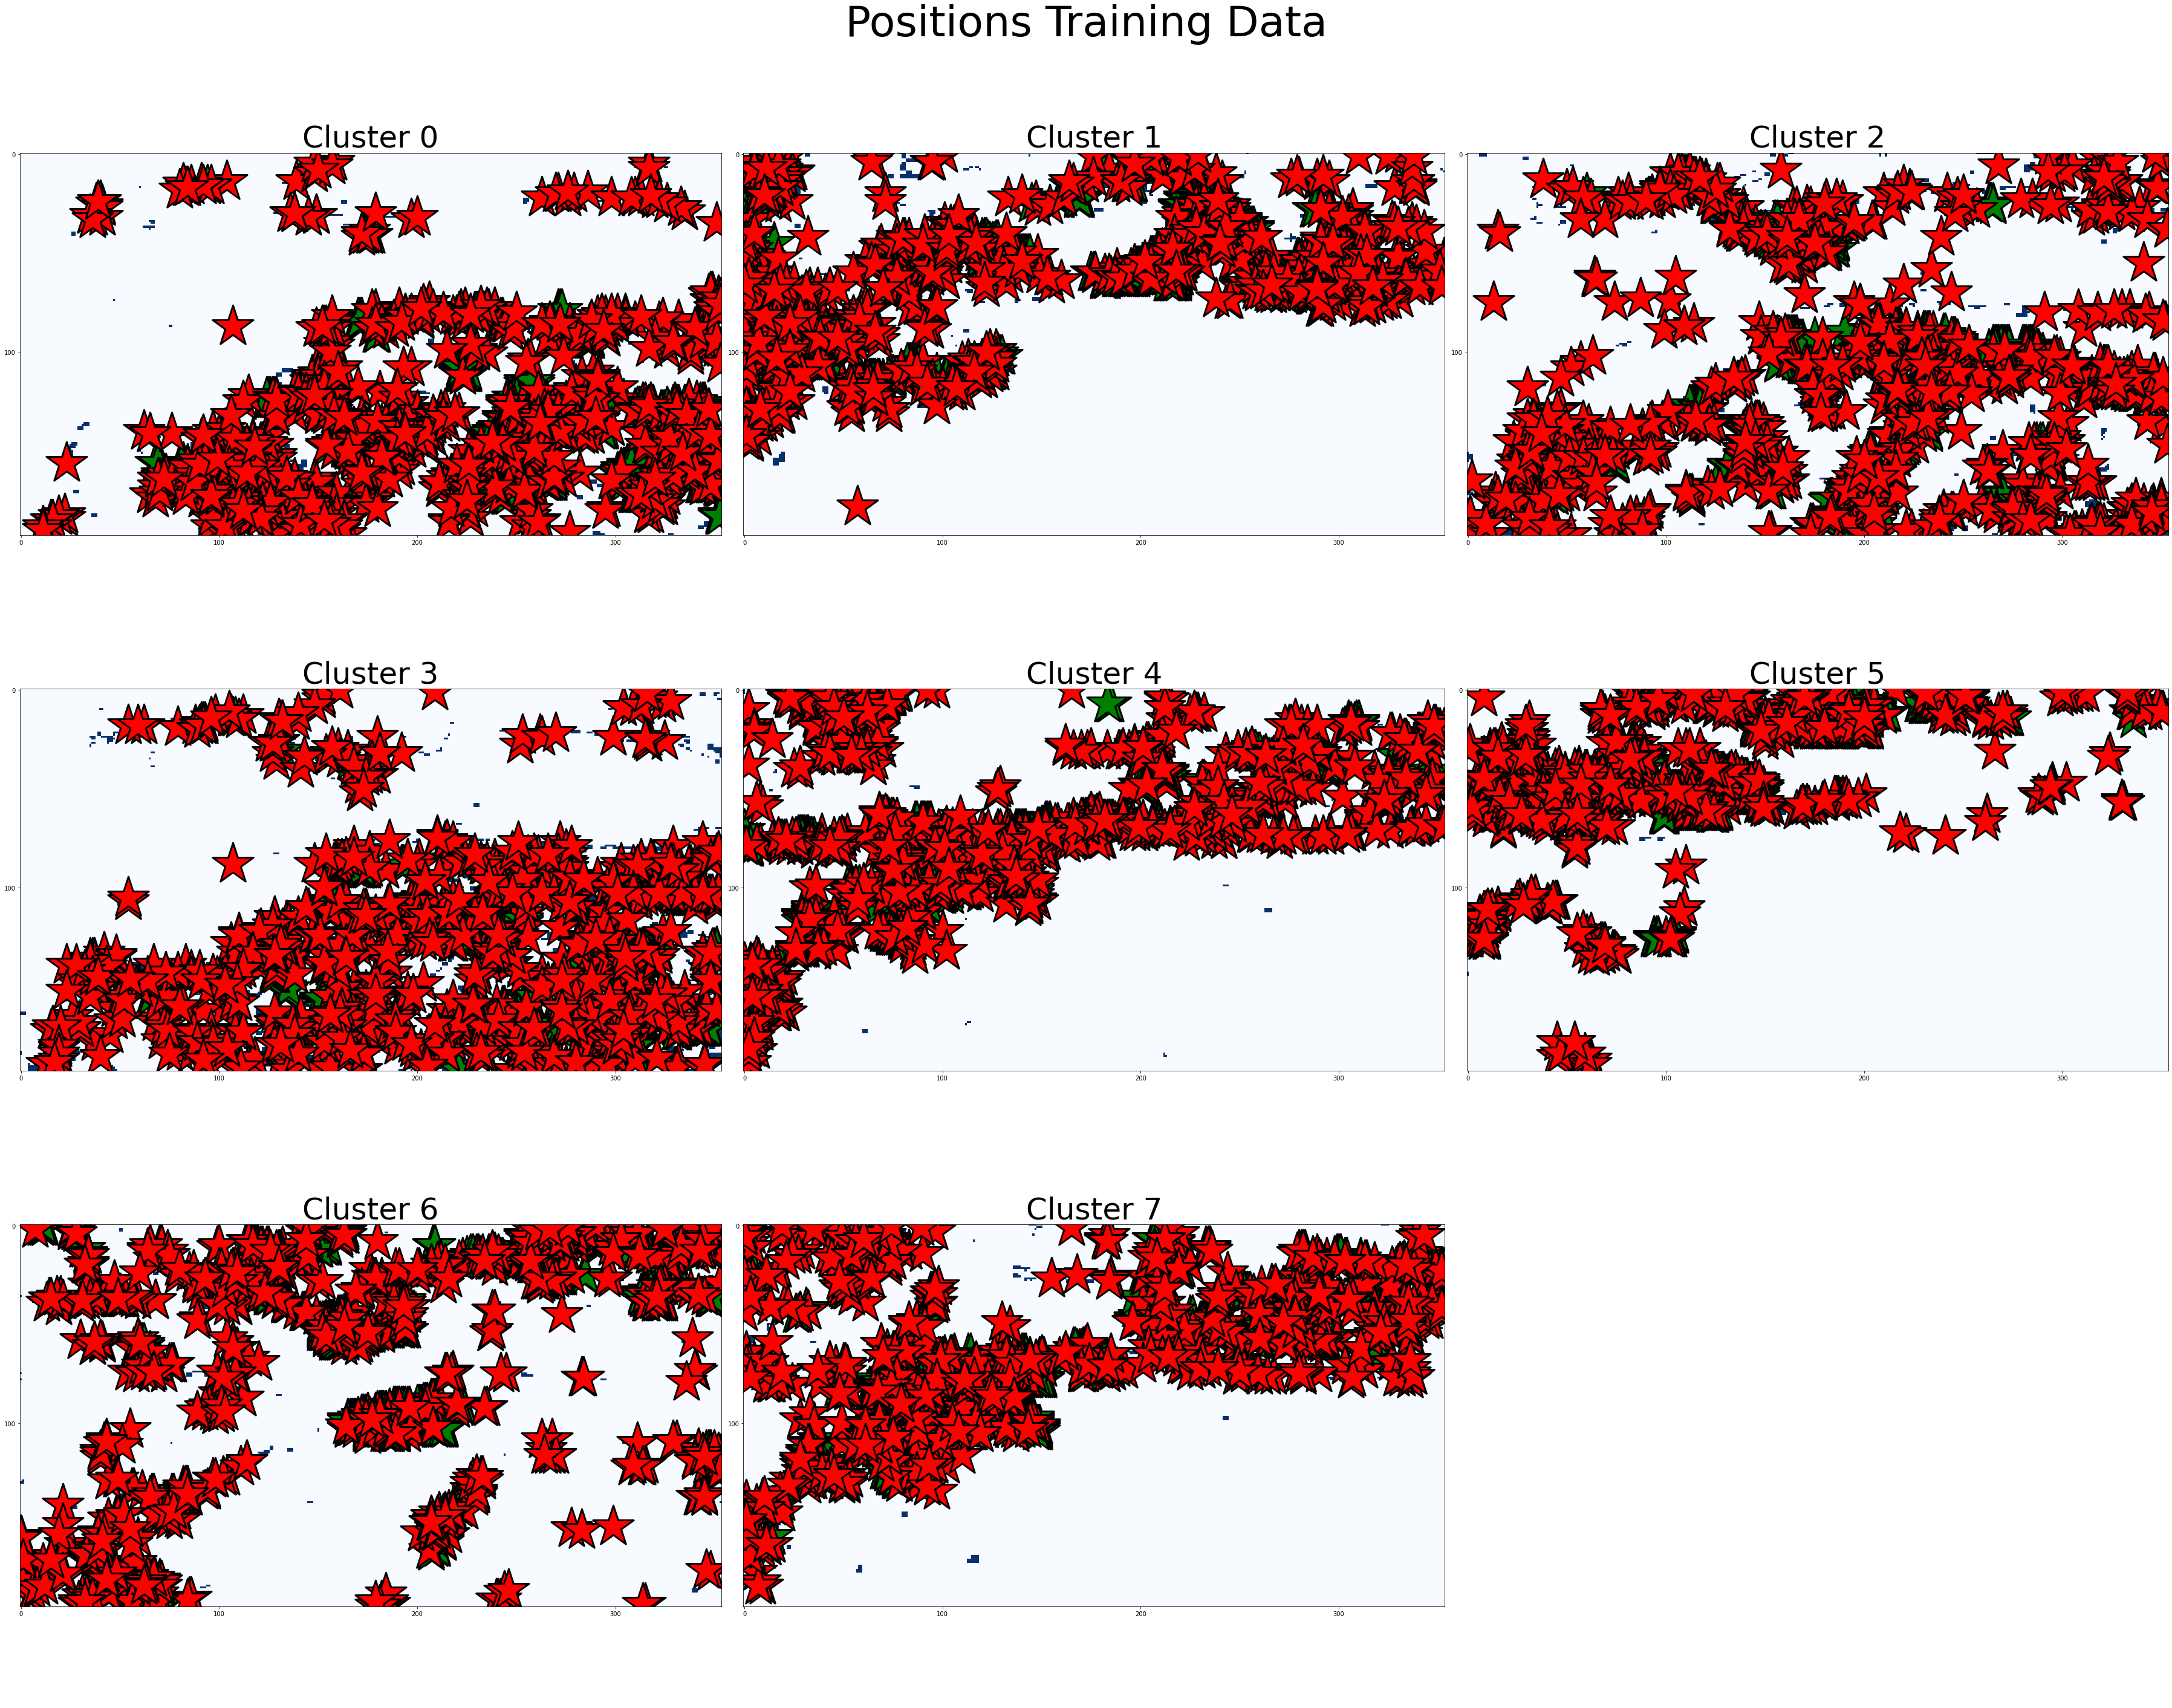

In [26]:
plt.figure()
# Prepare subplots
n_figures = n_clusters
n_rows = int(math.ceil((n_figures)**(1/2))) #add an extra row to have space for the colorbar
n_cols = int(math.ceil(n_figures/n_rows))
rows=[]
columns = []
for row in range(n_rows):
    for col in range(n_cols):
        rows.append(row)
        columns.append(col)

# Subplots and figure title
fig, axs = plt.subplots(n_rows, n_cols, figsize= (50,40))
fig.suptitle(f'Positions Training Data', fontsize = 70)

# Pixels training positions for the cluster
for sp in range(n_figures):
    cluster = labels==sp
    ax = axs[rows[sp], columns[sp]]
    img = ax.imshow(cluster, cmap='Blues', interpolation='nearest')
    for pixel in rep_pix_allCluster[sp]:
        ax.scatter(pixel[1], pixel[0],color = 'green', marker='*', s=5000, edgecolor='black', linewidth=3)
    for pixel in rand_pix_allCluster[sp]:
        ax.scatter(pixel[1], pixel[0],color = 'red', marker='*', s=5000, edgecolor='black', linewidth=3)
    ax.set_xticks(np.arange(cluster.shape[1]+1, step=100))
    ax.set_xticks(np.arange(cluster.shape[1]+1, step=100))
    ax.set_yticks(np.arange(cluster.shape[0]+1, step=100))
    ax.set_title(f'Cluster {sp}', fontsize=50)

# delete empty figures
for image in range(n_figures, n_rows*n_cols):
    axs[rows[image], columns[image]].set_axis_off()

## Tight layout, save and show
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig(f'{figures_filepath}/training_pixel_positions.png', format='png', dpi=300)
plt.show()

**GET PIXEL TRAINING DATA**

In [27]:
pixel_training = []
for b in range(len(bands)):
    data = []
    label_data = []
    for cluster in range(n_clusters):
        data_cluster = []
        name = f'Cluster {cluster}'
        label_data.append(name)
        pixels = rep_pix_allCluster[cluster]
        for img in range(training.shape[0]):
            for pixel in pixels:
                pixel = training[img, b, pixel[0], pixel[1]]
                data_cluster.append(pixel)
        data.append(data_cluster)
    pixel_training.append(data)
pixel_training = np.array(pixel_training)
print('bands, clusters, images x pixels')
print(pixel_training.shape)

bands, clusters, images x pixels
(14, 8, 29600)


**SHOW TRAINING DATA: BOXPLOTS**

<Figure size 432x288 with 0 Axes>

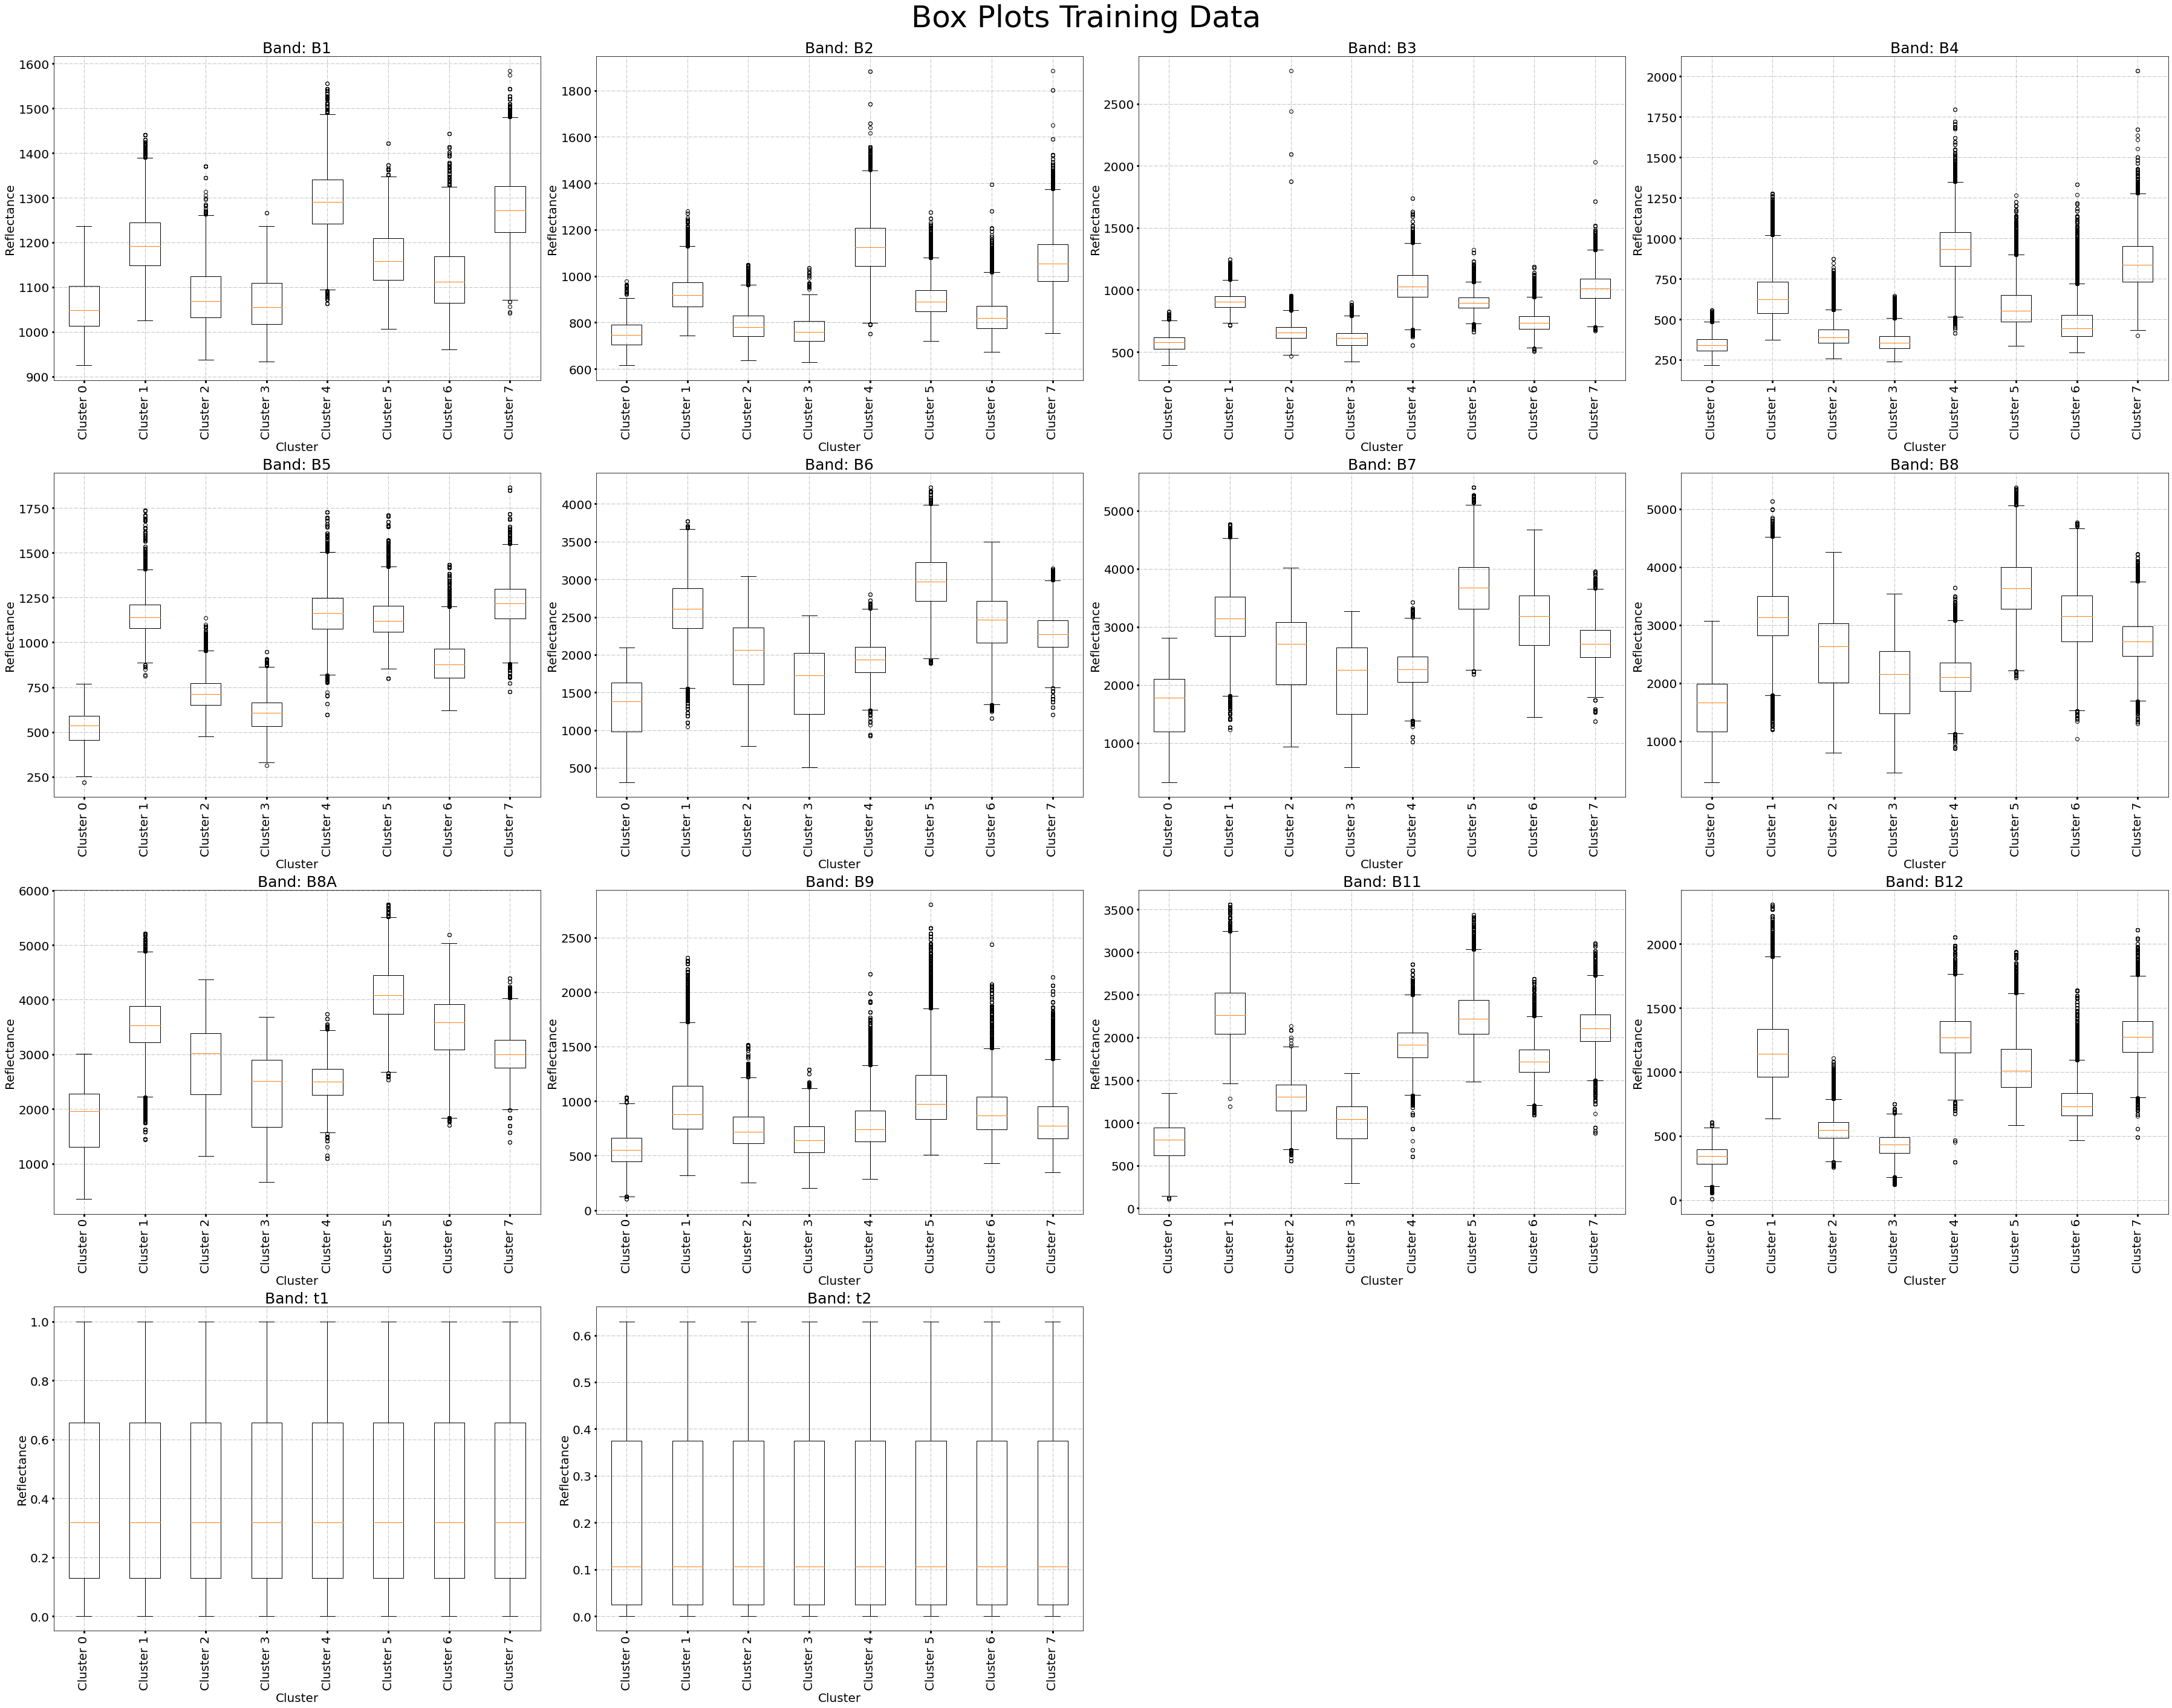

In [28]:
plt.figure()

# Prepare subplots
n_figures = len(bands)
n_rows = int(math.ceil((n_figures)**(1/2)))
n_cols = int(math.ceil(n_figures/n_rows))
rows=[]
columns = []
for row in range(n_rows):
    for col in range(n_cols):
        rows.append(row)
        columns.append(col)

# Subplots and figure title
fig, axs = plt.subplots(n_rows, n_cols, figsize= (50,40))
fig.suptitle(f'Box Plots Training Data', fontsize = 50)

# Represent Data
for sp in range(n_figures):     
    data = pixel_training[sp]
    ax = axs[rows[sp], columns[sp]]
    ax.boxplot(data.transpose())
    ax.set_title(f'Band: {bands[sp]}', fontsize=25)
    ax.set_xlabel('Cluster', fontsize=20)
    ax.set_ylabel('Reflectance', fontsize=20)
    ax.grid(True, linestyle='-.')
    ax.tick_params(labelsize=20, width=3)
    plt.sca(axs[rows[sp], columns[sp]])
    plt.xticks(list(range(1,len(label_data)+1)), label_data, rotation='vertical')

# delete empty figures
for image in range(n_figures, n_rows*n_cols):
    axs[rows[image], columns[image]].set_axis_off()

## Tight layout, save and show
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig(f'{figures_filepath}/boxplots_training.png', format='png', dpi=300)
plt.show()

**SHOW TRAINING DATA: BANDS**

In [29]:
plt.figure()

# Prepare subplots
n_figures = n_clusters
n_rows = int(math.ceil((n_figures)**(1/2))) 
n_cols = int(math.ceil(n_figures/n_rows))
rows=[]
columns = []
for row in range(n_rows):
    for col in range(n_cols):
        rows.append(row)
        columns.append(col)

# Subplots and figure title
fig, axs = plt.subplots(n_rows, n_cols, figsize= (50,40))
fig.suptitle(f'Training Pixels Reflectances', fontsize = 60, fontweight="bold")

# Represent Data
for sp in range(n_figures):     
    data = pixel_training[1:-2,sp,:]
    ax = axs[rows[sp], columns[sp]]
    ax.plot(data)
    ax.set_title(f'Cluster: {sp}', fontsize=40)
    ax.set_xlabel('Bands', fontsize=30)
    ax.set_ylabel('Reflectance', fontsize=30)
    ax.grid(True, linestyle='-.')
    ax.tick_params(labelsize=30, width=3)
    ax.set_xticks(range(data.shape[0]))
    ax.set_xticklabels(bands[1:-2]);

# delete empty figures
for image in range(n_figures, n_rows*n_cols):
    axs[rows[image], columns[image]].set_axis_off()

# add a comment
textstr = '**Only the most representative pixel of training data is plotted'
plt.gcf().text(0, -0.01, textstr, fontsize=50)

## Tight layout, save and show
plt.tight_layout()
fig.subplots_adjust(top=0.93)
plt.savefig(f'{figures_filepath}/bandsShape_training.png', format='png', dpi=300)
plt.show()

<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

**SHOW TRAINING DATA: BANDS ALONG TIME**

plt.figure()

# Prepare subplots
n_figures = n_clusters
n_rows = int(math.ceil((n_figures)**(1/2)))
n_cols = int(math.ceil(n_figures/n_rows))
rows=[]
columns = []
for row in range(n_rows):
    for col in range(n_cols):
        rows.append(row)
        columns.append(col)

# Subplots and figure title
fig, axs = plt.subplots(n_rows, n_cols, figsize= (40,60))
fig.suptitle(f'Training Pixels Reflectances along time', fontsize = 60, fontweight="bold")

# Represent Data

for sp in range(n_figures):     
    data = np.transpose(pixel_training[:-2,sp,:])
    ax = axs[rows[sp], columns[sp]]
    im = ax.plot(data)
    ax.set_title(f'Cluster: {sp}', fontsize=40)
    ax.set_xlabel('DOY', fontsize=30)
    ax.set_ylabel('Reflectance', fontsize=30)
    ax.grid(True, linestyle='-.')
    ax.tick_params(labelsize=20, width=3)
    ax.set_xticks(range(data.shape[0]))
    #ax.set_xticklabels(doys, rotation=90);

# delete empty figures
for image in range(n_figures, n_rows*n_cols):
    axs[rows[image], columns[image]].set_axis_off()
    
# legend
leg = plt.legend(im, bands[:-2], loc=4, fontsize = 40)

# add a comment
textstr = '**Only the most representative pixel of the training data is plotted'
plt.gcf().text(0, -0.01, textstr, fontsize=50)

## Tight layout, save and show
plt.tight_layout()
fig.subplots_adjust(top=0.93)
plt.savefig(f'{figures_filepath}/bandsShapeAlongTime_training.png', format='png', dpi=300)
plt.show()

**GET TESTING DATA**

In [ ]:
pixel_testing = []
for b in range(len(bands)):
    data = []
    for cluster in range(n_clusters):
        data_cluster = []
        pixels = rand_pix_allCluster[cluster]
        for img in range(training.shape[0]):
            for pixel in pixels:
                pixel = training[img, b, pixel[0], pixel[1]]
                data_cluster.append(pixel)
        data.append(data_cluster)
    pixel_testing.append(data)
pixel_testing = np.array(pixel_testing)
print('bands, clusters, images x pixels')
print(pixel_testing.shape)

# Scale each pixel

- Training pixels: generate scaler and transform

In [ ]:
scaler = pp.MinMaxScaler()

pixel_trainingScaled = []    
    
for cluster in range(n_clusters):
    pixel_training_cluster = np.transpose(pixel_training[:, cluster, :]) #images x bands
    pixel_trainingScaled_cluster = scaler.fit_transform(pixel_training_cluster)
    scalers_cluster = os.path.join(model_filepath, f'Scalers/Scaler_{cluster}')
    if not os.path.exists(scalers_cluster):
        os.mkdir(scalers_cluster)
    joblib.dump(scaler, scalers + f'/Scaler_{cluster}/' + '/scale.mod')
    pixel_trainingScaled.append(pixel_trainingScaled_cluster)
    
pixel_trainingScaled = np.array(pixel_trainingScaled)
pixel_trainingScaled.shape # clusters x images x bands

- Testing pixels: transform

In [ ]:
pixel_testingScaled = []    
    
for cluster in range(n_clusters):
    scaler_cluster = joblib.load(scalers + f'/Scaler_{cluster}/scale.mod')
    pixel_testing_cluster = np.transpose(pixel_testing[:, cluster, :]) #images x bands
    pixel_testingScaled_cluster = scaler_cluster.transform(pixel_testing_cluster)
    pixel_testingScaled.append(pixel_testingScaled_cluster)
    
pixel_testingScaled = np.array(pixel_testingScaled)
pixel_testingScaled.shape # clusters x images x bands

---------------------------------------------------------------------------------------------------------

# Autoencoder

In [ ]:
# early stopping
es = keras.callbacks.EarlyStopping(monitor = 'mse', mode = 'min', min_delta = 0.001, verbose = 2, patience = 12) 

start = time.time()

for ae in range(n_clusters):

    lowest_error = 100000000

    print(f'''-------------------------------------------------------------------------------------------
                                    CLUSTER {ae} --- AUTOENCODER {ae}
    ------------------------------------------------------------------------------------------------------''')

    ## Create a folder for the AE
    # Model filepaths
    folder = f'Autoencoder_{ae}'
    mf = os.path.join(model_filepath, folder)
    if not os.path.exists(mf):
          os.mkdir(mf)
    # Figures filepaths
    mf2 = os.path.join(figures_filepath, 'Training')
    if not os.path.exists(mf2):
          os.mkdir(mf2)
    mf3 = os.path.join(figures_filepath, 'Error')
    if not os.path.exists(mf3):
          os.mkdir(mf3)
    mf4 = os.path.join(figures_filepath, 'Reflectance')
    if not os.path.exists(mf4):
          os.mkdir(mf4)


    ## Prepare training data
    print('Preparing training data...')

    
    # Data of the selected pixels
    pixel_trainingScaled_cluster = pixel_trainingScaled[ae]
    pixel_testingScaled_cluster = pixel_testingScaled[ae]


    ## Train AE
    print('Training the model...')
    for n in range(6):
        # Create model
        model = Sequential()

        # Create layers
        model.add(Dense(units=n_hidden_neurons, activation='linear', input_dim=len(bands)))
        model.add(Dense(units=len(bands), activation='linear'))

        # Compile model (a traditional default value for the learning rate is 0.1 or 0.01)
        opt = keras.optimizers.Adam(learning_rate=0.01)
        tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
        model.compile(optimizer=opt, loss="mean_squared_error", metrics=['mse'])

        # Train
        X_train = pixel_trainingScaled_cluster
        X_test = pixel_testingScaled_cluster
        history = model.fit(x=X_train, y=X_train,
                            epochs=200,
                            batch_size= None,
                            shuffle=True,
                            validation_data=(X_test,X_test),
                            verbose=0,
                            callbacks=[es])

        # Save best model
        error = min(history.history['mse'])
        print(f'Min error: {error}')

        if error < lowest_error:
            lowest_error = error
            model.save(mf, overwrite=True, include_optimizer=True)
            # Plot train-test curves
            plt.plot(history.history['mse'])
            plt.plot(history.history['val_mse'])
            plt.title(f'MSE Train Test AE_{ae}')
            plt.ylabel('mse')
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.savefig(f'{mf2}/traintestCurvesAE_{ae}.png', format='png', dpi=300)
            plt.show()
        pass

end = time.time()

print(f'Running time AEs --- minutes ----{(end-start)/60}')

# Predictions

In [ ]:
# Figures filepaths
mf2 = os.path.join(figures_filepath, 'Training')
mf3 = os.path.join(figures_filepath, 'Error')
mf4 = os.path.join(figures_filepath, 'Reflectance')

# RECONSTRUCT TRAINING DATA

In [ ]:
scalers = os.path.join(model_filepath, 'Scalers')
reconstruction = []

for ae in list(range(n_clusters)):
    
    # Upload models
    mf = f'{model_filepath}/Autoencoder_{ae}/'
    model = keras.models.load_model(mf)
    scaler_cluster = joblib.load(scalers + f'/Scaler_{cluster}/scale.mod')
    
    # Scale
    trainScaled_AE = scaler_cluster.transform(train_AE)
    
    ## Prediction
    print(f'Predicting autoencoder {ae}...')
    start_p = time.time()
    recScaled_AE = model.predict(x=trainScaled_AE, verbose=1)
    
    # Descale
    reconstruction_AE = scaler_cluster.inverse_transform(recScaled_AE)
    
    # Convert to original shape
    reconstruction_cluster = reconstruction_AE.transpose()
    reconstruction_cluster = reconstruction_cluster.reshape(training.shape[1], training.shape[0], training.shape[2], training.shape[3])
    images = []
    for img in range(training.shape[0]):
        bands_img = []
        for b in range(training.shape[1]):
            band = reconstruction_cluster[b, img, :, :]
            bands_img.append(band)
        images.append(bands_img)
    reconstruction_cluster = np.array(images)
    reconstruction.append(reconstruction_cluster)
    end_p = time.time()
    print(f'Prediction time AE_{ae} ---minutes--- {(end_p-start_p)/60}')

reconstruction = np.array(reconstruction)

**SHOW PIXEL RECONSTRUCTION (MOST REPRESENTATIVE PIXEL PER CLUSTER)**

In [ ]:
from matplotlib.cbook import flatten
# Prepare subplots
n_figures = len(bands)
n_rows = int(math.ceil((n_figures)**(1/2))) #add an extra row to have space for the colorbar
n_cols = int(math.ceil(n_figures/n_rows))
rows=[]
columns = []
for row in range(n_rows):
    for col in range(n_cols):
        rows.append(row)
        columns.append(col)

# Show reflectances for each AE
for ae in range(n_clusters):
    print(f'''-------------------------------------------------------------------------------------------
                                    CLUSTER {ae} --- AUTOENCODER {ae}
    ------------------------------------------------------------------------------------------------------''')
    
    # Plot reflectances original pixel vs. reconstructed
    reconstruction_cluster = reconstruction[ae]
    pixels = rep_pix_allCluster[ae]
    pixel = pixels[0]
    fig, axs = plt.subplots(n_rows, n_cols, figsize= (50,40))
    rms_l = []
    
    # reflectance bands: B1, B2, B3, B4, B5
    for sp in range(n_figures):
        ori_sublist = []
        pre_sublist = []
        for pixel in pixels:
            ori_pixel = list(training[:,sp, pixel[0], pixel[1]])
            ori_sublist.append(ori_pixel)
            pre_pixel = list(reconstruction_cluster[:,sp, pixel[0], pixel[1]])
            pre_sublist.append(pre_pixel)
        #print(ori_sublist)
        #print(pre_sublist)
        ori = list(flatten(ori_sublist))
        pre = list(flatten(pre_sublist))
        rms = round(mean_squared_error(ori, pre, squared=False),3)
        rms_l.append(rms)
        ax = axs[rows[sp], columns[sp]]
        im = ax.scatter(ori, pre)
        ax.set_xlim(min(min(list(ori)), min(list(pre))), max(max(list(ori)), max(list(pre))))
        ax.set_ylim(min(min(list(ori)), min(list(pre))), max(max(list(ori)), max(list(pre))))
        ax.set_title(f'{bands[sp]} - RMSE = {rms}', fontsize=25)
        ax.set_xlabel('Original', fontsize=20)
        ax.set_ylabel('Predicted', fontsize=20)
        ax.grid(True, linestyle='-.')
        ax.tick_params(labelsize=20, width=3)
    
    # delete empty figures
    for sp in range(n_figures, n_rows*n_cols):
        axs[rows[sp], columns[sp]].set_axis_off()

    plt.title(f'Reflectances Representative Pixel Cluster_{ae}: original vs predicted', fontsize=10)
    plt.tight_layout()
    plt.savefig(f'{mf4}/OriginalvsReconstructed_AE_{ae}.png', format='png', dpi=300)
    plt.show()
    
    # print total RMSE
    print('Sum RMSE all bands...')
    print(f'Total RMSE autoencoder {ae}: {np.sum(np.array(rms_l))}')
    
    # save RMSE
    dict = {'RMSE' : np.sum(np.array(rms_l))}
    f = open( f'{model_filepath}/RMSE_pixel_training_reconstruction.txt', 'w')
    f.write( repr(dict) + '\n' )
    f.close()

# PREDICT TEST DATA

In [ ]:
scalers = os.path.join(model_filepath, 'Scalers')
prediction = []

for ae in list(range(n_clusters)):
    
    # Upload models
    mf = f'{model_filepath}/Autoencoder_{ae}/'
    model = keras.models.load_model(mf)
    scaler_cluster = joblib.load(scalers + f'/Scaler_{cluster}/scale.mod')
    
    # Scale
    testScaled_AE = scaler_cluster.transform(test_AE)
    
    ## Prediction
    print(f'Predicting autoencoder {ae}...')
    start_p = time.time()
    predScaled_AE = model.predict(x=testScaled_AE, verbose=1)
    
    # Descale
    prediction_AE = scaler_cluster.inverse_transform(predScaled_AE)

    # Convert to original shape
    prediction_cluster = prediction_AE.transpose()
    prediction_cluster = prediction_cluster. reshape(testing.shape[0], testing.shape[1], testing.shape[2])
    prediction.append(prediction_cluster)
    end_p = time.time()
    print(f'Prediction time AE_{ae} ---minutes--- {(end_p-start_p)/60}')

prediction = np.array(prediction)

**Calculate error: RMSE (with scaled values)**

In [ ]:
error_list = []
ae=0
for prediction_cluster in prediction:    
    print(f'Calculating error autoencoder {ae}...')
    ae=ae+1
    
    # RMSE y=bands of one image -> predicted vs original + mean of the RMSE between all images
    dif = (prediction_cluster[:-2,:,:]-testing[:-2,:,:])**2
    suma = np.sum(dif, axis = 0)
    div = suma/(testing.shape[0]-2)
    square = div**(1/2)
    error_list.append(square)

error_list = np.array(error_list)

**Plot error**

In [ ]:
##hyperparameters (visualization)
vmin= 0
vmax= 10

In [ ]:
# Prepare subplots
n_figures = n_clusters
n_rows = int(math.ceil((n_figures)**(1/2))) +1
n_cols = int(math.ceil(n_figures/n_rows))
fig, axs = plt.subplots(n_rows, n_cols, figsize= (50,40))
rows=[]
columns = []
for row in range(n_rows):
    for col in range(n_cols):
        rows.append(row)
        columns.append(col)

# RMSE in each subplot: plot error matrices
cm = 'jet'
for ae in range(n_figures):
    mean = error_list[ae]
    cluster = labels==ae
    ax = axs[rows[ae], columns[ae]]
    im = ax.imshow(mean, cmap=cm, vmax=100)
    ax.contour(cluster, colors='black', linewidths=1.5)
    ax.set_xticks(np.arange(mean.shape[1]+1, step=100))
    ax.set_yticks(np.arange(mean.shape[0]+1, step=100))
    ax.grid(color='black', linewidth=0.3)
    ax.set_title(f'RMSE -- AE_{ae}', fontsize=30)

# delete empty figures
for image in range(n_figures, n_rows*n_cols):
    axs[rows[image], columns[image]].set_axis_off()

# colorbar
cb = plt.colorbar(im, orientation="horizontal", pad=0.15)
cb.set_label(label='RMSE', size=30, weight='bold')
cb.ax.tick_params(labelsize=30)

# save
plt.tight_layout()
#plt.savefig(f'{mf3}/RMSE_all_AE.png', format='png', dpi=300)
plt.show()

**Min Error of All Autoencoders in AOI**

In [ ]:
##hyperparameters (visualization)
vmin1= 0
vmax1= 100

In [ ]:
## Min Error of All Autoencoders
print(f'''-------------------------------------------------------------------------------------------
                                        MINIMUM VALUE OF ERRORS
    ------------------------------------------------------------------------------------------------------''')
error = error_list.min(axis=0)
# Plot min error
fig, ax = plt.subplots(figsize=(5,5), dpi=300)
ax = plt.imshow(error, cmap='bwr', interpolation = 'nearest',vmin=vmin1, vmax=vmax1)
plt.xticks(np.arange(error.shape[1]+1, step=100), fontsize=5, rotation=90)
plt.yticks(np.arange(error.shape[0]+1, step=100), fontsize=5, rotation=0)
plt.grid(color='black', linewidth=0.3)
plt.title(f'Min Error through all AEs', fontsize=10)
fig.colorbar(ax, orientation='horizontal')
#plt.savefig(f'{mf3}/min_error.png', format='png', dpi=300)
plt.show()

**REPRESENT MIN ERROR BOUNDING CLUSTERS**

In [ ]:
plt.figure()
# Prepare subplots
n_figures = n_clusters
n_rows = 4 
n_cols = 2
rows=[]
columns = []
for row in range(n_rows):
    for col in range(n_cols):
        rows.append(row)
        columns.append(col)

# Subplots and figure title
fig, axs = plt.subplots(n_rows, n_cols, figsize= (40,60))
fig.suptitle(f'Min RMSE + Cluster Bounds', fontsize = 60, fontweight="bold")

# RMSE in each subplot: plot error matrices
cm = 'jet'
for sp in range(n_figures):
    cluster = labels==sp
    ax = axs[rows[sp], columns[sp]]
    im = ax.imshow(error, cmap='bwr', interpolation = 'nearest',vmin=vmin, vmax=vmax)
    ax.contour(cluster, colors='black', linewidths=2)
    ax.set_xticks(np.arange(error.shape[1]+1, step=100))
    ax.set_yticks(np.arange(error.shape[0]+1, step=100))
    ax.grid(color='black', linewidth=0.3)
    ax.set_title(f'RMSE -- AE_{sp}', fontsize=50)

# delete empty figures
for image in range(n_figures, n_rows*n_cols):
    axs[rows[image], columns[image]].set_axis_off()

# colorbar
cb = plt.colorbar(im, orientation="horizontal", pad=0.15)
cb.set_label(label='RMSE', size=30, weight='bold')
cb.ax.tick_params(labelsize=30)

# save
fig.subplots_adjust(top=0.9)
plt.tight_layout()
plt.savefig(f'{mf3}/minRMSE_ClusterBounds.png', format='png', dpi=300)
plt.show()

In [ ]:
plt.figure(figsize = (15,15))

files = sorted(os.listdir(path_images))
for f in files:
    if not f.startswith(('.','Strobler', 'Test')) and f.endswith(('.tif')) and os.path.isfile(os.path.join(path_images, f)):
        # Labels
        flood = gdal_array.LoadFile(path_images+f)

error = error_list.min(axis=0)
plt.imshow(error, cmap='bwr', interpolation = 'nearest',vmin=vmin1, vmax=vmax1)
plt.contour(flood==1, colors='black', linewidths=1.5)
plt.grid(color='black', linewidth=0.3)
plt.title(f'RMSE and Flood Bound', fontsize=15)
#fig.colorbar(ax, orientation='horizontal')
plt.savefig(f'{mf3}/minError_FloodBound.png', format='png', dpi=300)
plt.show()

# Reconstruction

**AUTOENCODERS**

In [ ]:
# Autoencoder of each pixel
for y in range(testing.shape[1]):
    for x in range(testing.shape[2]):
        for c in range(n_clusters):
            if error[y,x] == error_list[c, y, x]:
                error[y,x] = c
            else:
                pass

In [ ]:
plt.figure()

# discrete colormap (n samples from a given cmap)
cmap = sns.color_palette('tab20', n_clusters) 
fig, ax = plt.subplots(dpi=300) 
ax = sns.heatmap(error, cmap=cmap) 

# modify colorbar:
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n_clusters * (0.5 + i) for i in range(n_clusters)])
colorbar.set_ticklabels(list(range(n_clusters)))
plt.grid(color='black', linewidth=0.3)

#save and plot
plt.savefig(f'{figures_filepath}/Clusters_Autoencoders.png', format='png', dpi=300)
plt.show()

**TRUE COLOR COMPOSITE**

In [ ]:
best_pred = []
for c in range(n_clusters):
    cluster = error == c
    prediction_cluster = prediction[c]
    pred_cluster = cluster * prediction_cluster
    best_pred.append(pred_cluster)
best_pred = np.array(best_pred)
best_pred = np.sum(best_pred, axis = 0)
best_pred.shape

In [ ]:
plt.figure(figsize = (15,15))
image = best_pred
img = np.dstack((image[3, ...]/1500, image[2, ...]/1500, image[1, ...]/1500))
img = np.clip(img, 0, 1)
plt.imshow(np.array(img))
plt.grid(color='black', linewidth=0.3)
plt.title(f'Prediction Flood Image', fontsize=15)
plt.savefig(f'{figures_filepath}/reconstruction_TCC.png', format='png', dpi=300)
plt.show()

# End :)